## Naive approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rcParams["figure.figsize"] = (25,15)

In [82]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

In [4]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [5]:
homes= pd.read_csv("homes.csv", infer_datetime_format=True, index_col=0)

In [6]:
energy= homes['total_a']
energy= energy.dropna()
energy = energy.values
energy= energy.reshape(len(energy),1)

In [7]:
# Data partitining 
train_size  = int(len(energy) * 0.80)
test_size   = len(energy) - train_size
train, test = energy[:train_size], energy[train_size:]

In [8]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [6]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
timesteps = 1 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(14090, 1, 1)

In [15]:
model = Sequential()
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [16]:
# Training
history= model.fit(X_train, y_train, epochs=110, batch_size=24, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/110
588/588 - 3s - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0081 - val_mse: 0.0081 - 3s/epoch - 6ms/step
Epoch 2/110
588/588 - 1s - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0071 - val_mse: 0.0071 - 1s/epoch - 2ms/step
Epoch 3/110
588/588 - 1s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0070 - val_mse: 0.0070 - 1s/epoch - 2ms/step
Epoch 4/110
588/588 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0070 - val_mse: 0.0070 - 1s/epoch - 2ms/step
Epoch 5/110
588/588 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0070 - val_mse: 0.0070 - 1s/epoch - 2ms/step
Epoch 6/110
588/588 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0069 - val_mse: 0.0069 - 992ms/epoch - 2ms/step
Epoch 7/110
588/588 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0069 - val_mse: 0.0069 - 1s/epoch - 2ms/step
Epoch 8/110
588/588 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0069 - val_mse: 0.0069 - 1s/epoch - 2ms/step
Epoch 9/110
588/588 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0068 - val_mse: 0.0068 - 

In [17]:
pred_train ={}
pred_test = {}

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_train["simple_lstm"] = scaler.inverse_transform(
                              model.predict(X_train,verbose=0)).flatten()

pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

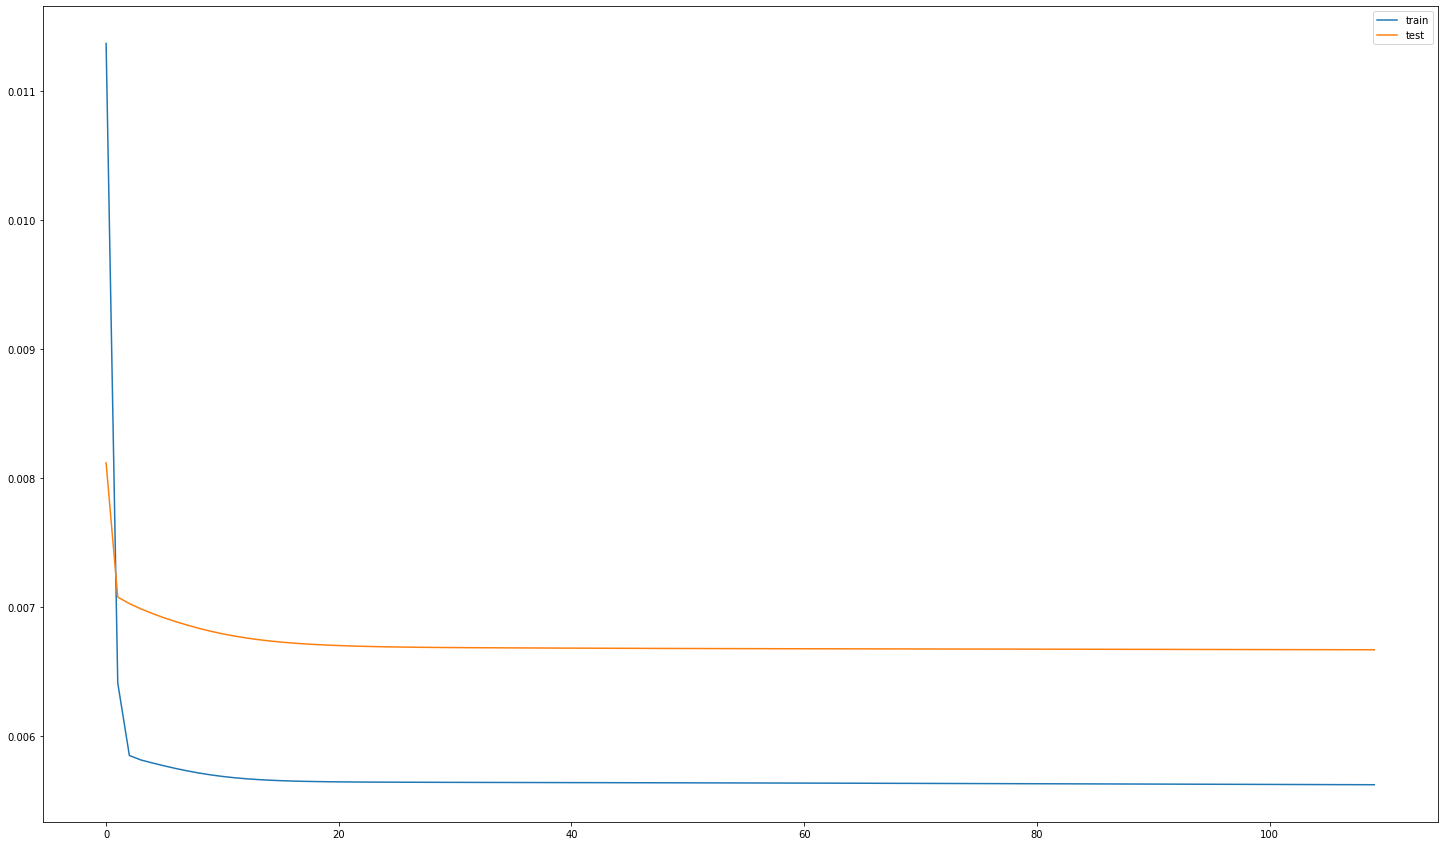

In [18]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

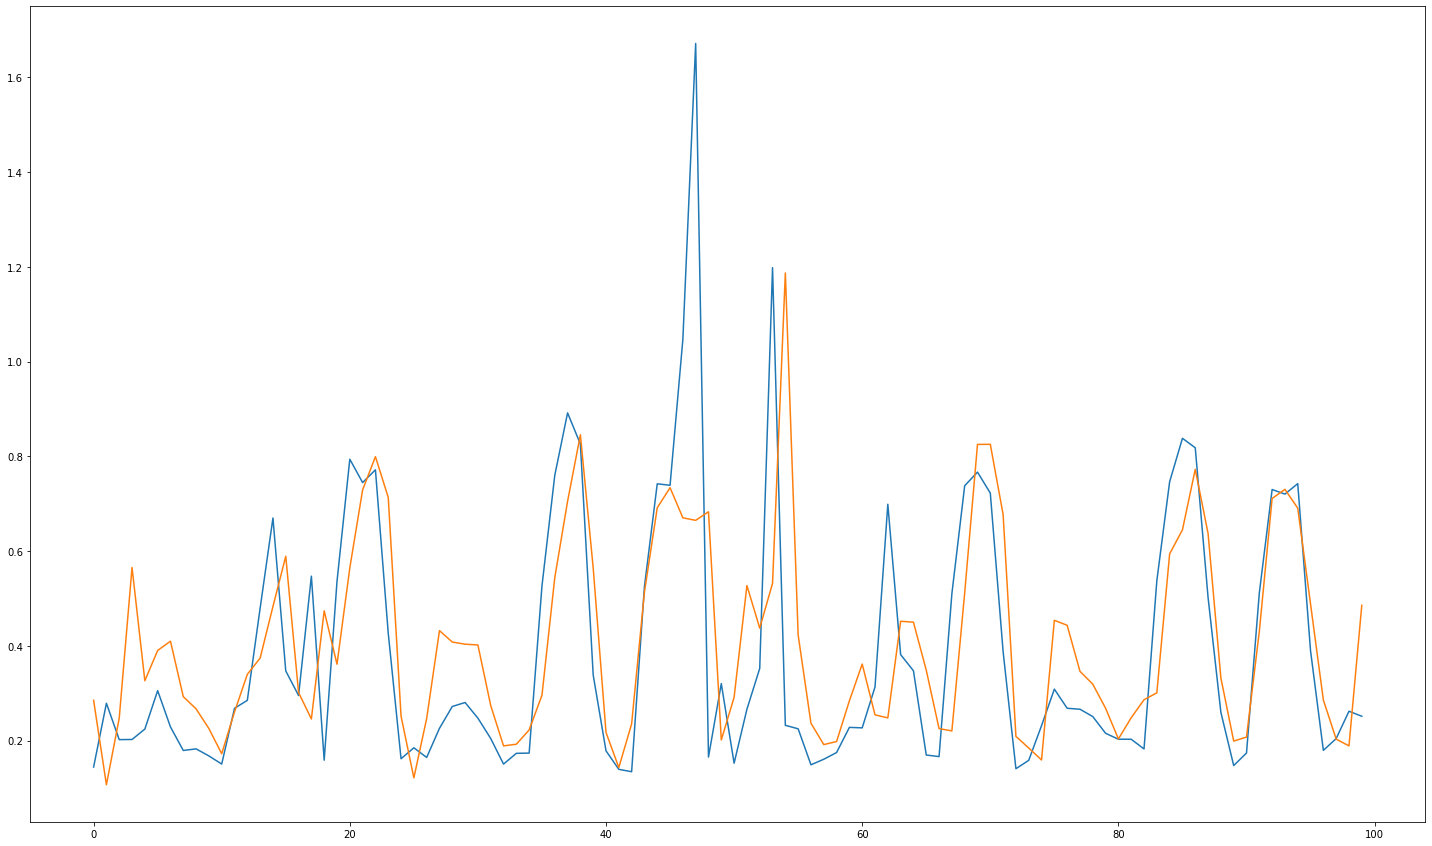

In [181]:
# plt.plot(pred_train['true'])
# plt.plot(pred_train['simple_lstm'])

plt.plot(pred_test['true'][0:100])
plt.plot(pred_test['simple_lstm'][0:100])
plt.show()


In [182]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [183]:
rmse_train={}
rmse_test={}

In [184]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["simple_lstm"])

In [188]:
rmse_test

{'naive': 0.2583147014240696}

In [315]:
def prepare_task(home, prop=0.8):

    home= home.dropna()
    home = home.values
    home= home.reshape(len(home),1)
    return home

    # # Data partitining 
    # train_size  = int(len(home) * prop)
    # test_size   = len(home) - train_size
    # train, test = energy[:train_size], energy[train_size:]



    # # The LSTM input layer must be 3D
    # # Create the dataset with rolling window for the training set and test set
    # X_train, y_train  = create_dataset(train, timesteps)  # lookback
    # X_test, y_test    = create_dataset(test, timesteps)

In [316]:
energy1= homes['total_a']
energy1= prepare_task(energy1)

In [317]:
train, test = train_test_split(energy1, train_size=0.8, shuffle=False)

In [189]:
def scale(train, test):

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    return train, test

In [190]:
train, test = scale(train, test)

In [191]:
timesteps= 13
# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [192]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True))
stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False))
stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [193]:
history1=stateless_multilayer.fit(X_train, y_train, batch_size=24,epochs=50, validation_split=0.3 )

Epoch 1/50
411/411 [==============================] - 8s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 2/50
411/411 [==============================] - 5s 11ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 3/50
411/411 [==============================] - 4s 11ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/50
411/411 [==============================] - 4s 11ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/50
411/411 [==============================] - 5s 11ms/step - 

In [194]:
pred_train["multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)).flatten()

pred_test['multilayer'] = scaler.inverse_transform(stateless_multilayer.predict(X_test)).flatten()

In [204]:
pred_test = pd.DataFrame(pred_test)

<AxesSubplot:>

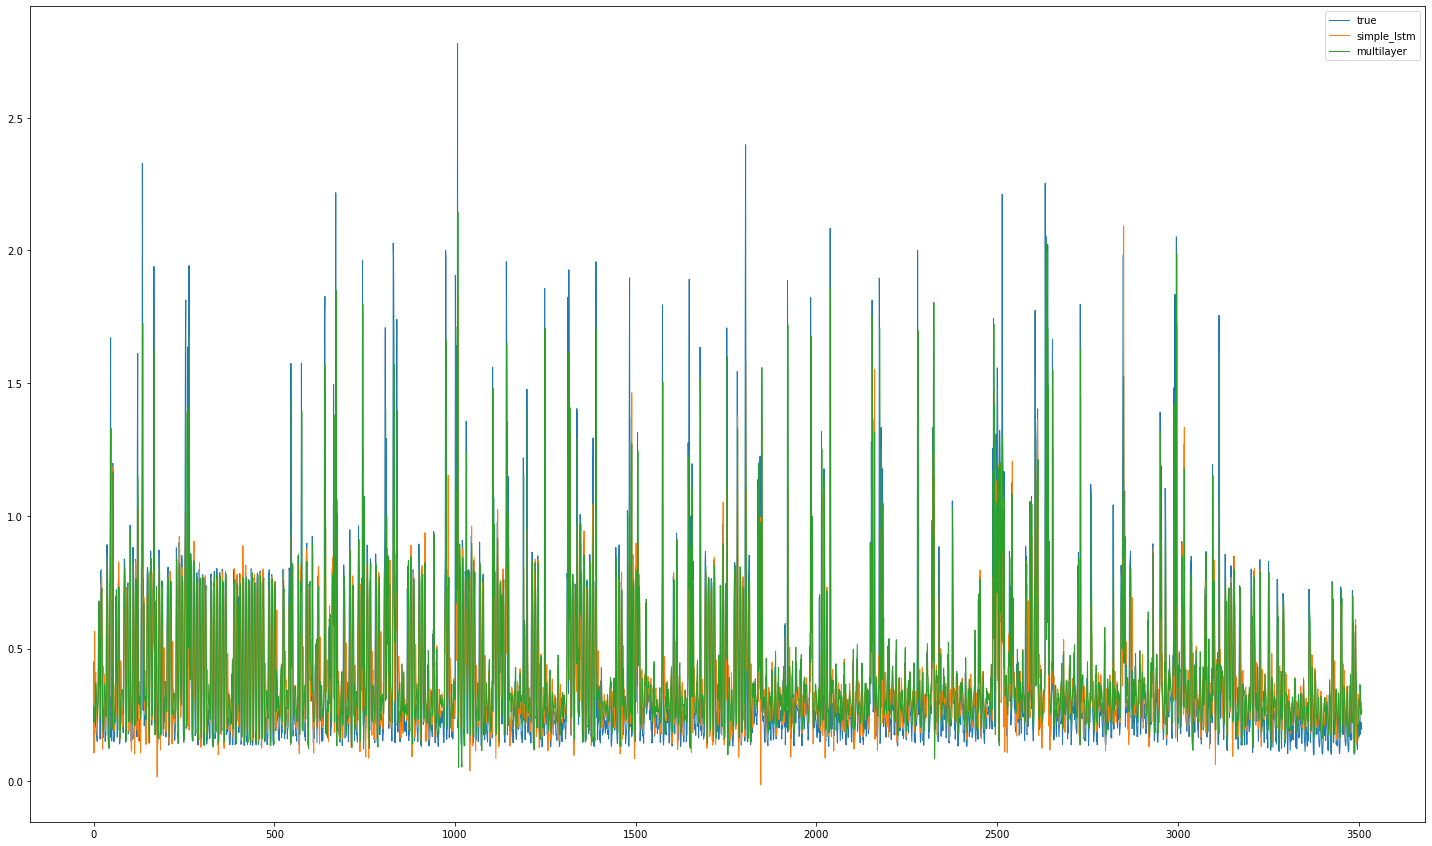

In [202]:
pd.DataFrame(pred_test).plot(lw=1)

In [196]:
rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["multilayer"])

In [197]:
rmse_train

{'naive': 0.2290306977116612, 'stateless_multilayer': 0.23954870727576888}

In [198]:
rmse_test

{'naive': 0.2583147014240696, 'stateless_multilayer': 0.28528711404753293}

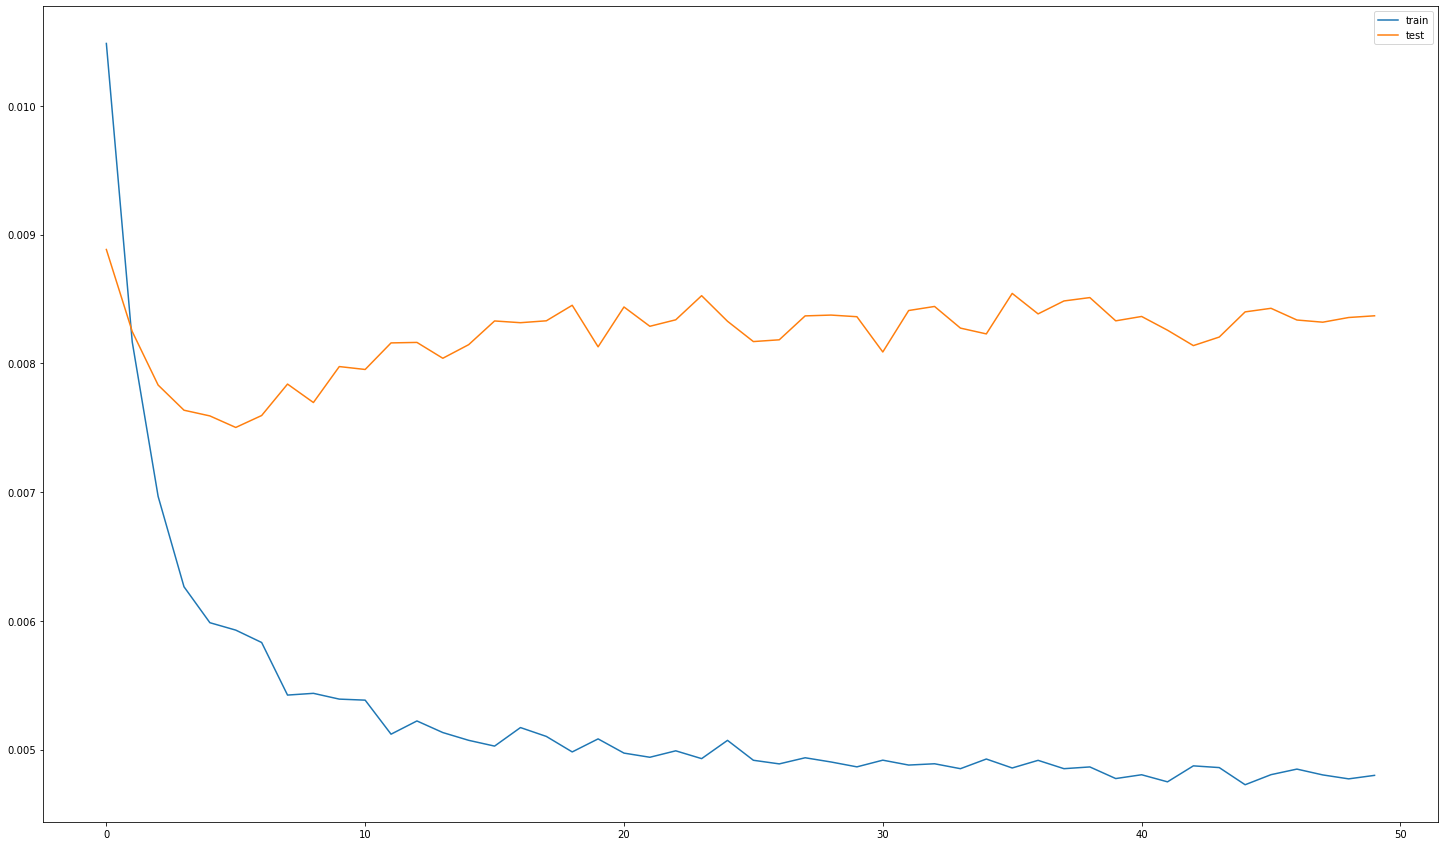

In [199]:
# plot history
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

### Multivariate Time Series forecasting with LSTMS

The approach for multivariate Time series forecasting consists of using a lagged version of all features to predict the present value of the target variable

In [22]:
example = homes

In [23]:
values = example.values
values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [24]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [25]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [227]:
itercols = [col for col in reframed.columns if '(t)' in col]
cols1 = [col for col in reframed.columns if '(t-' in col]

In [424]:
home_b = reframed.iloc[:,[1,2,4,8]]

<AxesSubplot:>

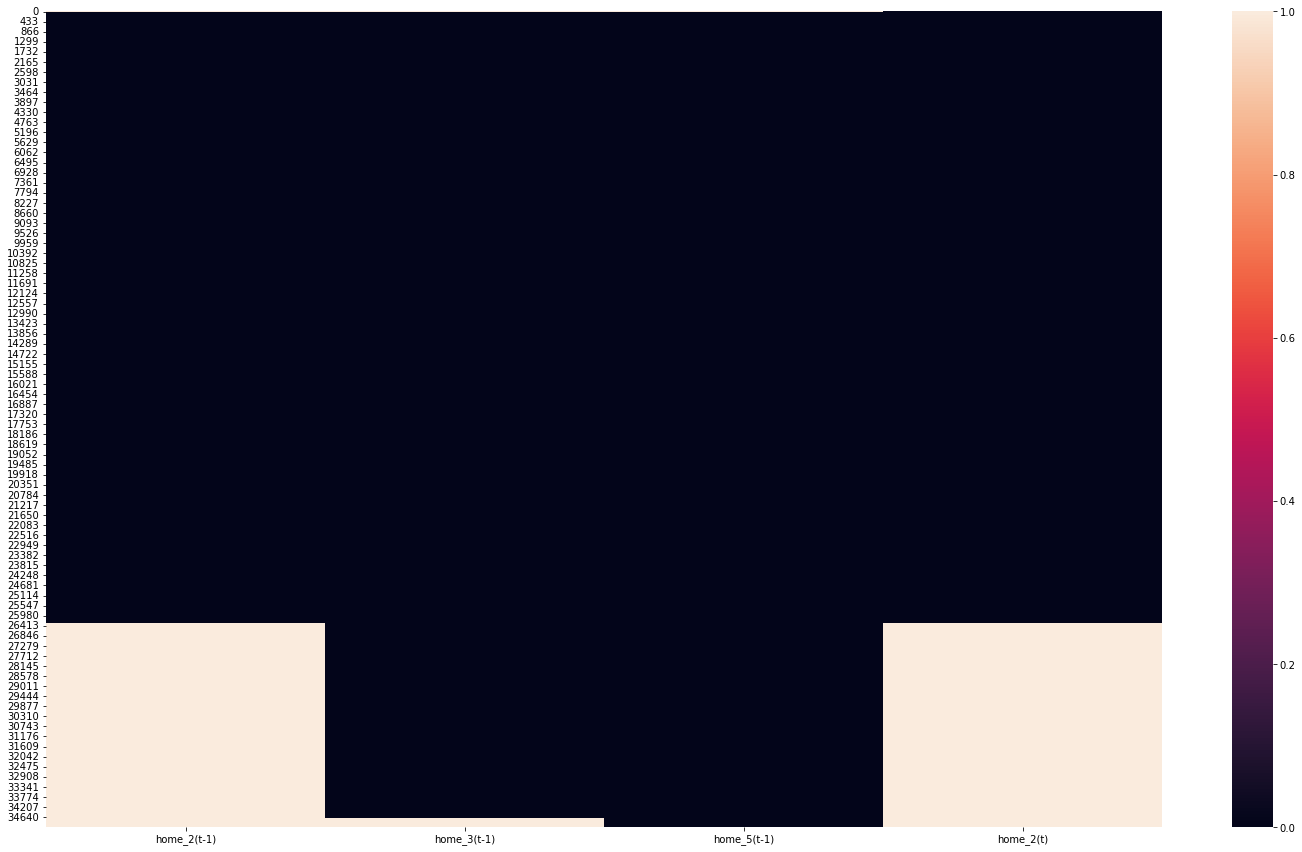

In [388]:
import seaborn as sns
sns.heatmap(home_b.isna())

In [425]:
home_b= home_b.dropna()

In [426]:
# split into train and test sets
values = home_b.values

train, test = train_test_split(values, train_size=0.9, shuffle=False)


In [427]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [428]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test =test[:, :-1], test[:,-1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23651, 1, 3) (23651,) (2628, 1, 3) (2628,)


In [429]:
# design network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [430]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 256)               266240    
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________


In [431]:
# fit network
history2 = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, shuffle=False)


Epoch 1/50
370/370 - 3s - loss: 0.0421 - 3s/epoch - 8ms/step
Epoch 2/50
370/370 - 1s - loss: 0.0335 - 1s/epoch - 4ms/step
Epoch 3/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 5ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0335 - 2s/epoch - 5ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 7/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 8/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 9/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 4ms/step
Epoch 10/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 11/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 4ms/step
Epoch 12/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 4ms/step
Epoch 13/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 14/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 15/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 16/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 17/50
370/3

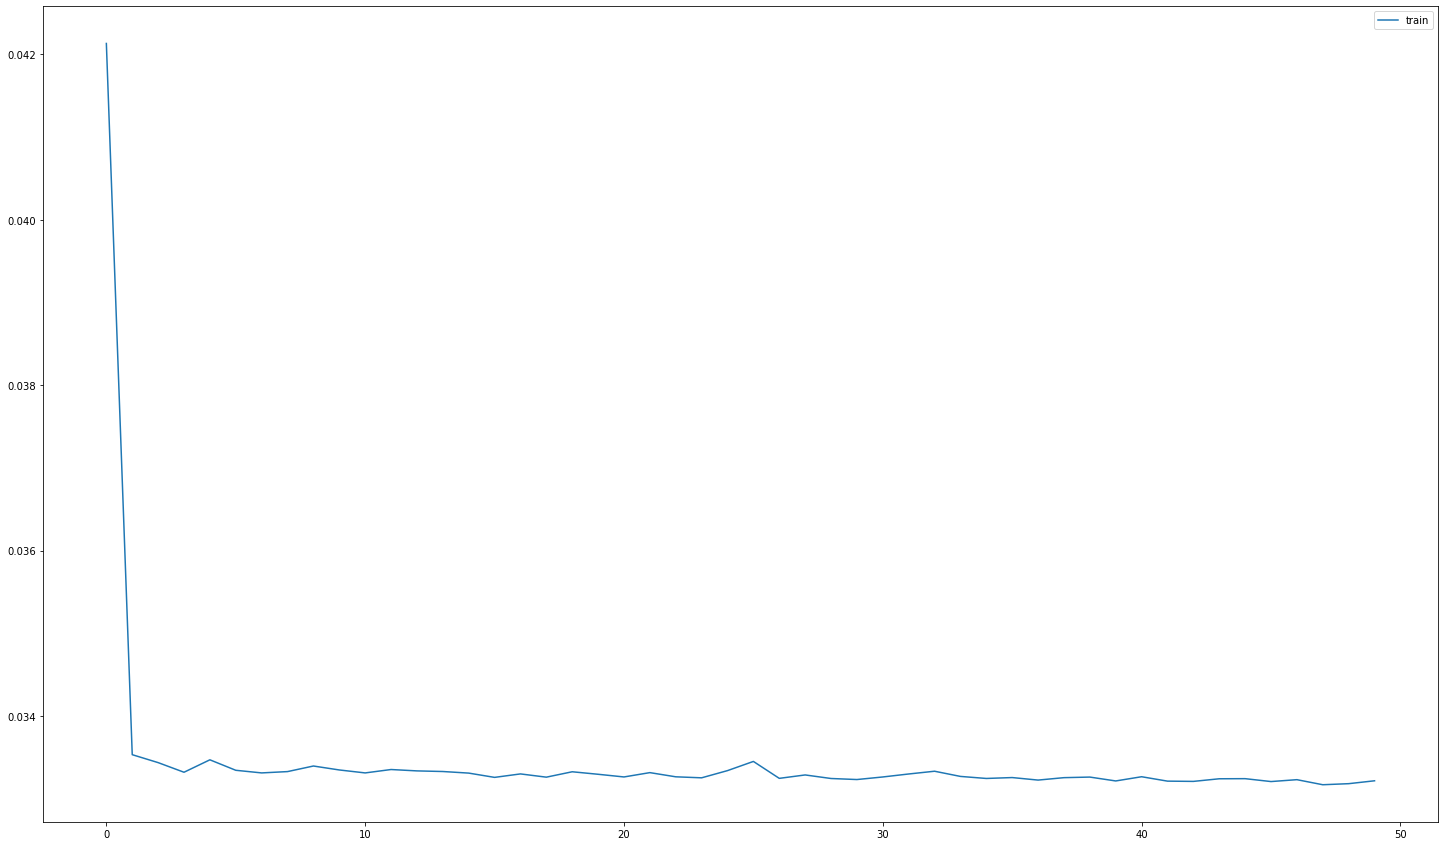

In [432]:
# plot history
plt.plot(history2.history['loss'], label='train')
#plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [434]:
#Predict model
yhat= model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((X_test, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,-1]
#Invert scaling for actual 
y_test = y_test.reshape(len(y_test),1)
inv_y= np.concatenate((X_test, y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,-1]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

print("Test RMSE %.3f" % rmse)

In [449]:
pred_b_train= {}
pred_b_test= {}

pred_b_test['true'] = inv_y
pred_b_test['multi'] = inv_yhat

In [453]:
rmse_b_train = {}
rmse_b_test = {}

In [163]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [457]:
# rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_b_test["naive"]  = rmse(pred_b_test["true"],  pred_b_test["multi"])

In [458]:
rmse_b_test

{'naive': 0.6942053}

In [461]:
pred_b_test = pd.DataFrame(pred_b_test)

In [466]:
pred_b_test['error'] = pred_b_test['true']-pred_b_test['multi']

In [465]:
home_b.iloc[23651:,:]

home_2(t-1)  home_3(t-1)  home_5(t-1)  home_2(t)
23652     1.629508     0.665316     1.526671   1.427628
23653     1.427628     0.480934     3.545602   1.427628
23654     1.427628     0.480934     3.545602   1.563216
23655     1.563216     1.355315     5.656806   1.563216
23656     1.563216     1.355315     5.656806   1.447643
...            ...          ...          ...        ...
26275     1.628335     1.658045    11.014453   1.628335
26276     1.628335     1.658045    11.014453   1.736318
26277     1.736318     1.516558     6.889673   1.736318
26278     1.736318     1.516558     6.889673   1.537199
26279     1.537199     1.883781     3.975907   1.537199

[2628 rows x 4 columns]

In [610]:
def train_model(df, train_size = 0.9, neurons = 256, epochs=50, batch_size=64):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean square'''
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=["mean_absolute_percentage_error", "mean_absolute_error"])


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    # plot history
    plt.plot(history2.history['loss'], label='train')
    #plt.plot(history2.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #Predict model
    yhat= model.predict(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
    inv_yhat = np.concatenate((X_test, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat=inv_yhat[:,-1]
    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    inv_y= np.concatenate((X_test, y_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)

    inv_y = inv_y[:,-1]

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error
   
    #pred_b_train= {}
    pred_b_test= {}

    pred_b_test['true'] = inv_y
    pred_b_test['multi'] = inv_yhat

    rmse_b_test["naive"]  = rmse(pred_b_test["true"],  pred_b_test["multi"])

    pred_b_test = pd.DataFrame(pred_b_test)
    print(rmse_b_test)

    pred_b_test.plot()

    return pred_b_test

    
    

    

    
    

In [472]:
reframed

home_1(t-1)  home_2(t-1)  home_3(t-1)  home_4(t-1)  home_5(t-1)  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN     1.676843     2.689820          NaN     2.060571   
2              NaN     2.167156     1.518391          NaN     1.212912   
3              NaN     1.102414     1.963862          NaN     1.342836   
4              NaN     1.910317     2.223022          NaN     1.549448   
...            ...          ...          ...          ...          ...   
35059     0.263403          NaN          NaN     7.307169     1.542869   
35060     0.177386          NaN          NaN     8.789098     1.479447   
35061     0.199725          NaN          NaN     8.362465     1.439440   
35062     0.222266          NaN          NaN     6.216546     1.410874   
35063     0.203904          NaN          NaN     6.726995     0.975436   

       home_6(t-1)  home_7(t-1)  home_1(t)  home_2(t)  home_3(t)  home_4(t)  \
0              NaN          NaN        NaN   1.676843   2.689820        NaN   
1              NaN          NaN        NaN   2.167156   1.518391        NaN   
2              NaN          NaN        NaN   1.102414   1.963862        NaN   
3              NaN          NaN        NaN   1.910317   2.223022        NaN   
4              NaN          NaN        NaN   1.479763   1.855156        NaN   
...            ...          ...        ...        ...        ...        ...   
35059     0.184146          NaN   0.177386        NaN        NaN   8.789098   
35060     0.669979          NaN   0.199725        NaN        NaN   8.362465   
35061     0.234510          NaN   0.222266        NaN        NaN   6.216546   
35062     0.278918          NaN   0.203904        NaN        NaN   6.726995   
35063     0.106219          NaN   0.196847        NaN        NaN   7.200723   

       home_5(t)  home_6(t)  home_7(t)  
0       2.060571        NaN        NaN  
1       1.212912        NaN        NaN  
2       1.342836        NaN        NaN  
3       1.549448        NaN        NaN  
4       2.604672        NaN        NaN  
...          ...        ...        ...  
35059   1.479447   0.669979        NaN  
35060   1.439440   0.234510        NaN  
35061   1.410874   0.278918        NaN  
35062   0.975436   0.106219        NaN  
35063   0.576490   0.106472        NaN  

[35064 rows x 14 columns]

In [484]:
home_c = reframed.iloc[:,[1,2,4,9]]
home_d = reframed.iloc[:,[0,2,3,4,5,10]]
home_f = reframed.iloc[:,[1,2,4,11]]
home_g= reframed.iloc[:,[0,2,3,4,5,6,12]]

(23652, 1, 3) (23652,) (2628, 1, 3) (2628,)
Epoch 1/50
370/370 - 3s - loss: 0.0383 - mean_absolute_percentage_error: 14561.4609 - mean_absolute_error: 0.0383 - 3s/epoch - 9ms/step
Epoch 2/50
370/370 - 2s - loss: 0.0266 - mean_absolute_percentage_error: 9448.8555 - mean_absolute_error: 0.0266 - 2s/epoch - 4ms/step
Epoch 3/50
370/370 - 2s - loss: 0.0265 - mean_absolute_percentage_error: 9693.5488 - mean_absolute_error: 0.0265 - 2s/epoch - 4ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0265 - mean_absolute_percentage_error: 9521.2646 - mean_absolute_error: 0.0265 - 2s/epoch - 4ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0264 - mean_absolute_percentage_error: 9563.7656 - mean_absolute_error: 0.0264 - 2s/epoch - 4ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0264 - mean_absolute_percentage_error: 9351.3184 - mean_absolute_error: 0.0264 - 2s/epoch - 4ms/step
Epoch 7/50
370/370 - 2s - loss: 0.0264 - mean_absolute_percentage_error: 9479.2246 - mean_absolute_error: 0.0264 - 2s/epoch - 4ms/step
Epoch 8/50

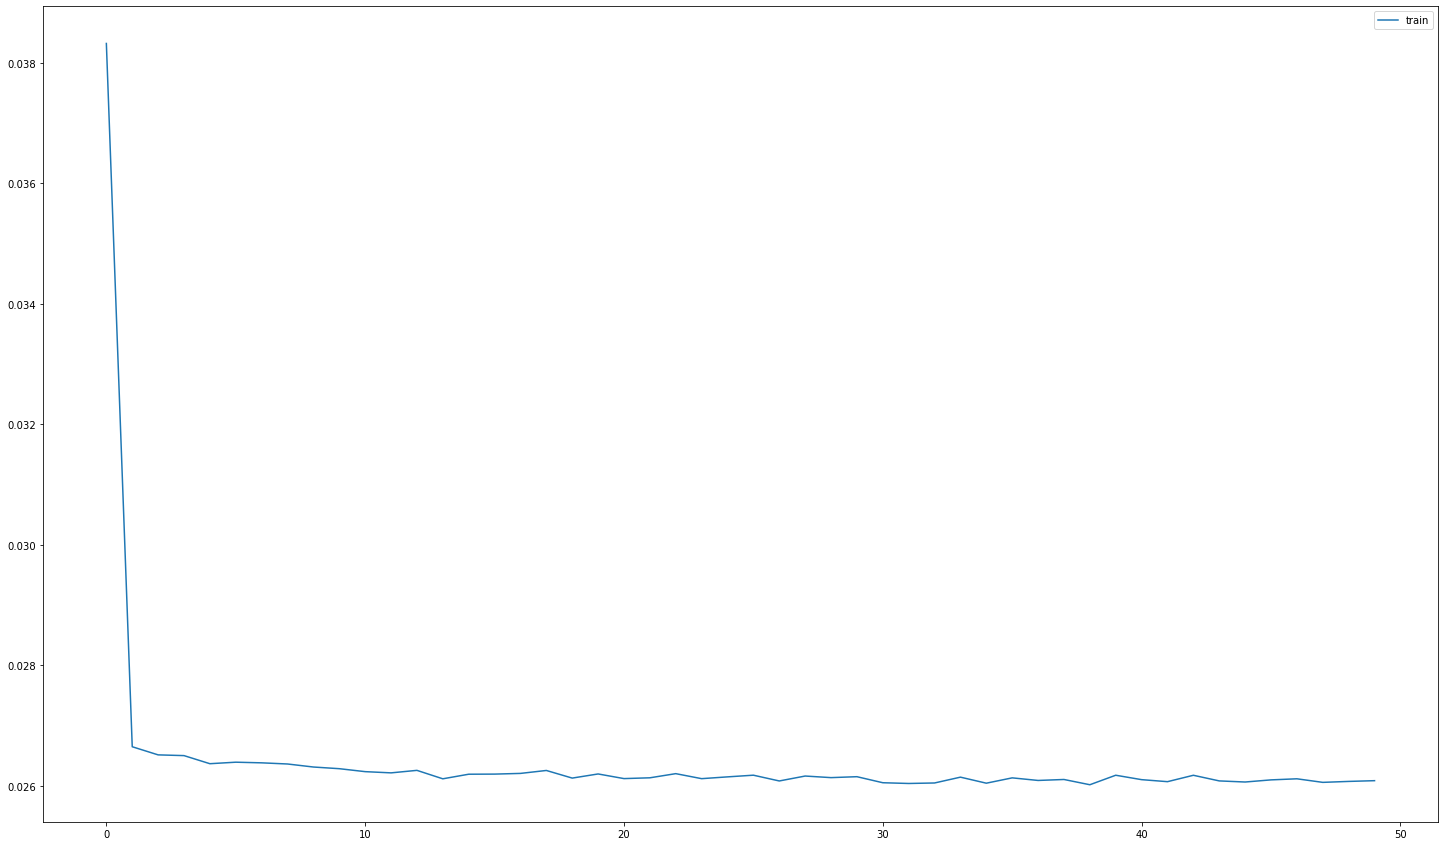

{'naive': 0.45561862}


true     multi
0     0.480934  0.481629
1     1.355315  0.481629
2     1.355315  1.345887
3     2.060117  1.345887
4     2.060117  2.047921
...        ...       ...
2623  1.516558  1.647298
2624  1.516558  1.505648
2625  1.883781  1.505648
2626  1.883781  1.871258
2627  1.860227  1.871258

[2628 rows x 2 columns]

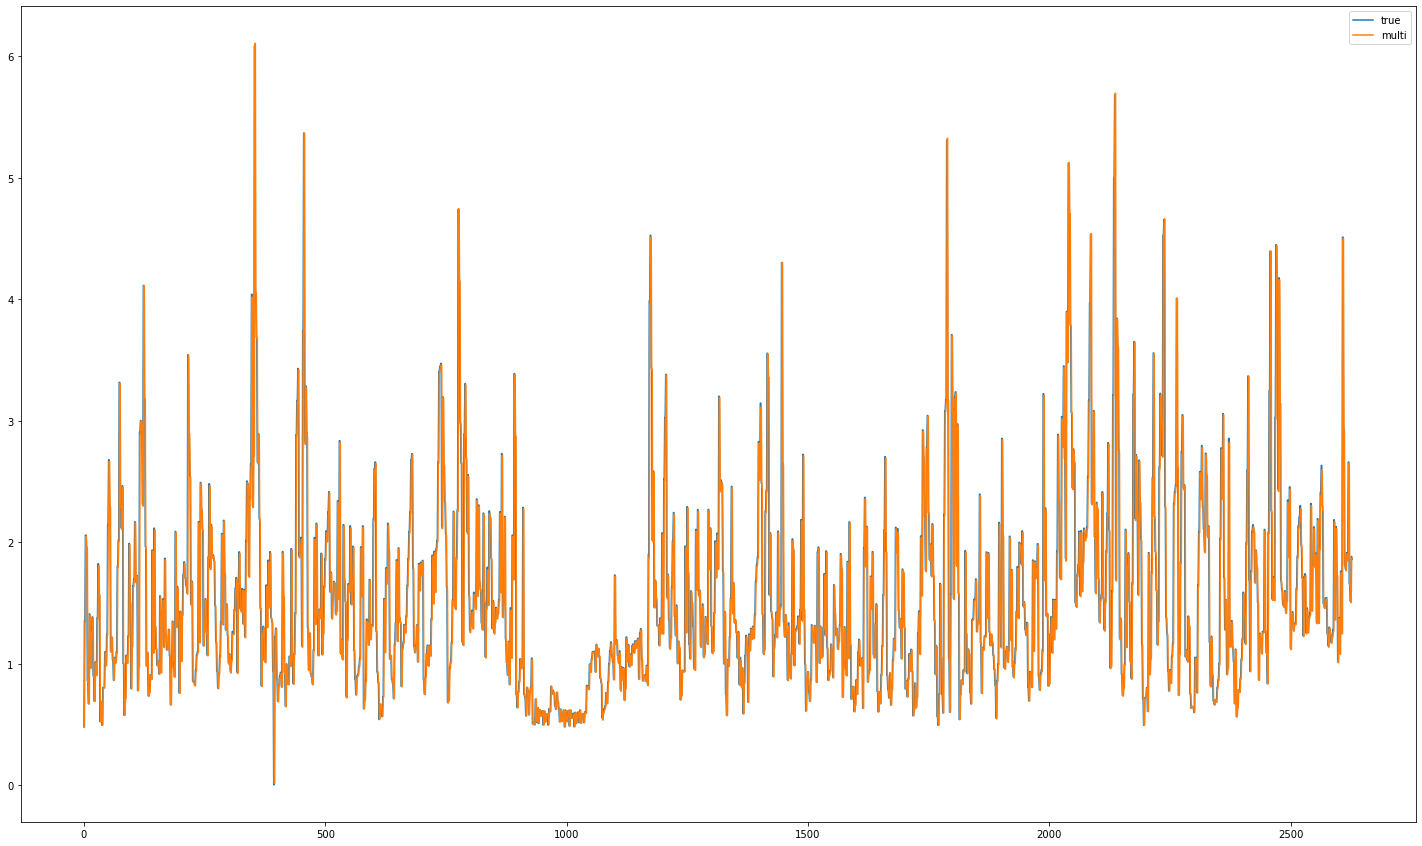

In [613]:
train_model(home_c)

(12654, 1, 5) (12654,) (1407, 1, 5) (1407,)
Epoch 1/50
198/198 - 2s - loss: 0.0724 - mean_absolute_percentage_error: 4171.4697 - mean_absolute_error: 0.0724 - 2s/epoch - 11ms/step
Epoch 2/50
198/198 - 1s - loss: 0.0478 - mean_absolute_percentage_error: 2057.9595 - mean_absolute_error: 0.0478 - 821ms/epoch - 4ms/step
Epoch 3/50
198/198 - 1s - loss: 0.0477 - mean_absolute_percentage_error: 2089.0977 - mean_absolute_error: 0.0477 - 851ms/epoch - 4ms/step
Epoch 4/50
198/198 - 1s - loss: 0.0475 - mean_absolute_percentage_error: 1977.7385 - mean_absolute_error: 0.0475 - 851ms/epoch - 4ms/step
Epoch 5/50
198/198 - 1s - loss: 0.0474 - mean_absolute_percentage_error: 1962.5457 - mean_absolute_error: 0.0474 - 831ms/epoch - 4ms/step
Epoch 6/50
198/198 - 1s - loss: 0.0473 - mean_absolute_percentage_error: 1897.3329 - mean_absolute_error: 0.0473 - 847ms/epoch - 4ms/step
Epoch 7/50
198/198 - 1s - loss: 0.0473 - mean_absolute_percentage_error: 2016.4114 - mean_absolute_error: 0.0473 - 830ms/epoch - 4

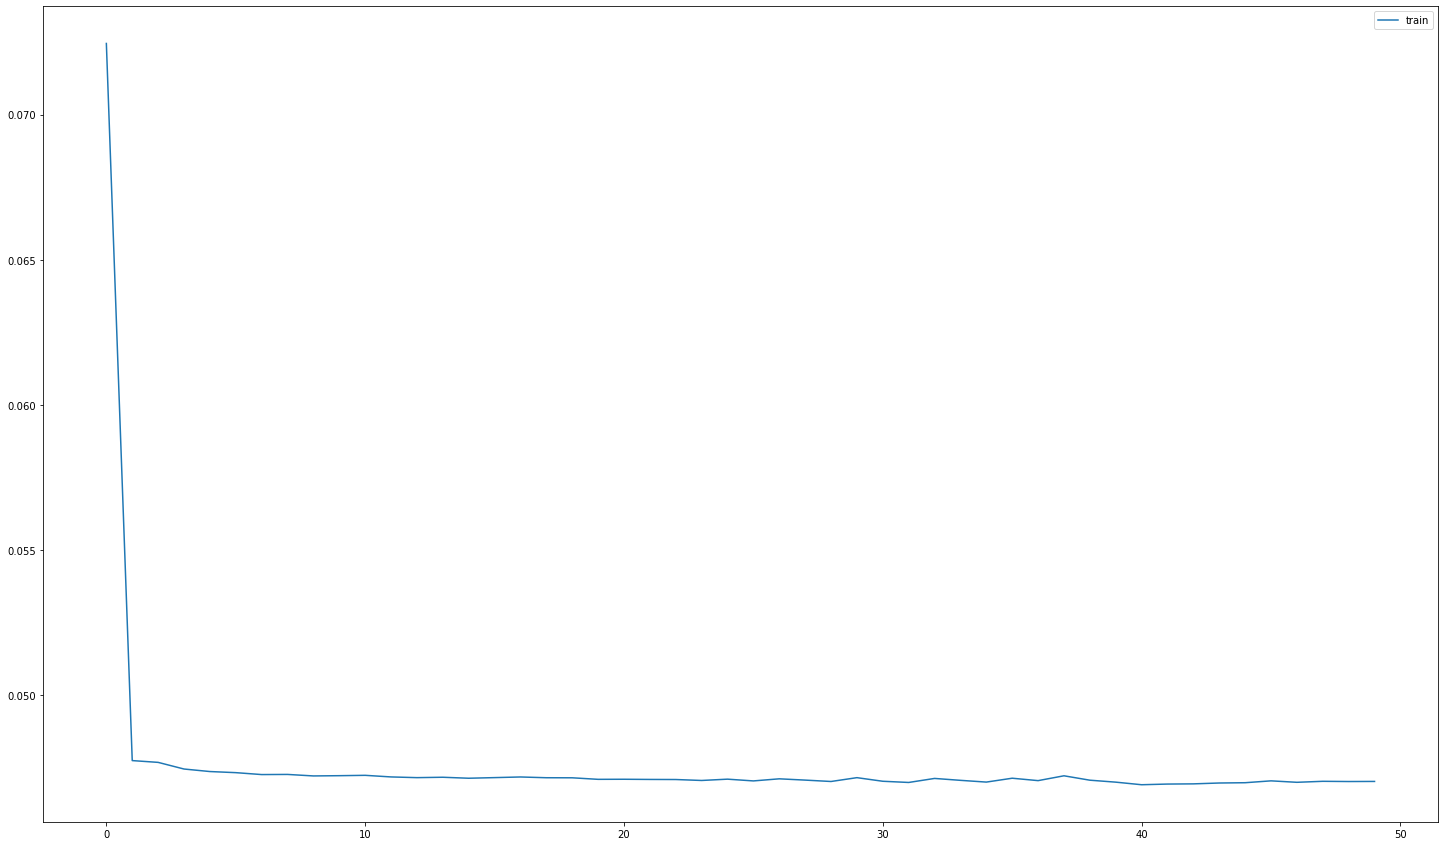

{'naive': 2.6869109}


true     multi
0     1.645347  0.524019
1     3.620700  1.574680
2     4.240813  3.370787
3     4.364341  3.848875
4     4.238812  4.019647
...        ...       ...
1402  5.718519  5.118991
1403  4.957617  5.041614
1404  4.777308  4.331275
1405  3.900701  4.589159
1406  2.965888  3.553894

[1407 rows x 2 columns]

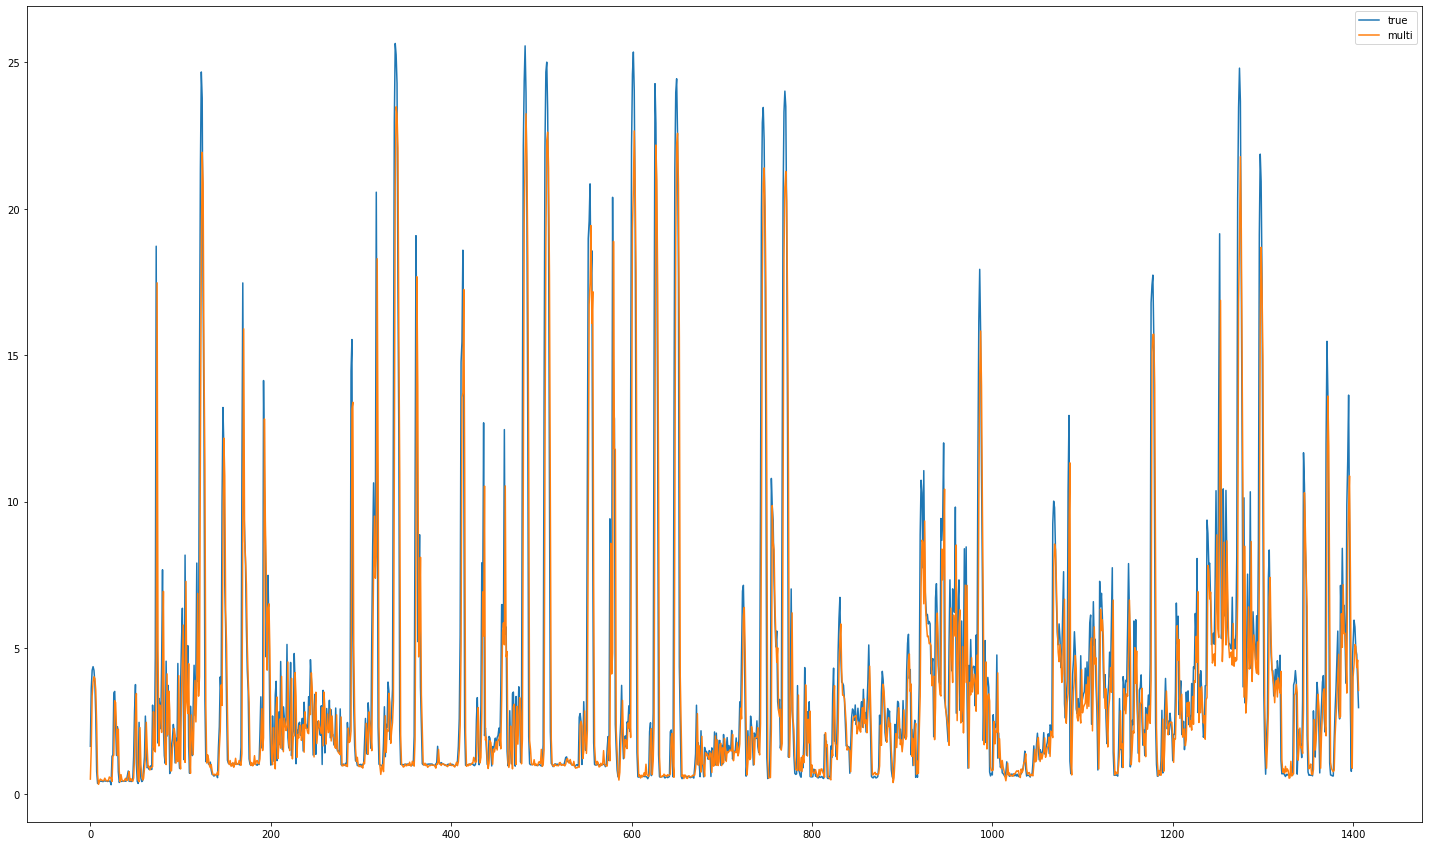

In [612]:
train_model(home_d, train_size=0.9, neurons=256, epochs=50, batch_size=64)

(23652, 1, 3) (23652,) (2628, 1, 3) (2628,)
Epoch 1/50
370/370 - 3s - loss: 0.0183 - mean_absolute_percentage_error: 1805.4248 - mean_absolute_error: 0.0183 - 3s/epoch - 8ms/step
Epoch 2/50
370/370 - 2s - loss: 0.0151 - mean_absolute_percentage_error: 1201.2299 - mean_absolute_error: 0.0151 - 2s/epoch - 5ms/step
Epoch 3/50
370/370 - 2s - loss: 0.0151 - mean_absolute_percentage_error: 1259.6908 - mean_absolute_error: 0.0151 - 2s/epoch - 4ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0149 - mean_absolute_percentage_error: 1471.2474 - mean_absolute_error: 0.0149 - 2s/epoch - 5ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0149 - mean_absolute_percentage_error: 1197.4452 - mean_absolute_error: 0.0149 - 2s/epoch - 5ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0149 - mean_absolute_percentage_error: 1235.7390 - mean_absolute_error: 0.0149 - 2s/epoch - 7ms/step
Epoch 7/50
370/370 - 2s - loss: 0.0150 - mean_absolute_percentage_error: 1236.9332 - mean_absolute_error: 0.0150 - 2s/epoch - 6ms/step
Epoch 8/50


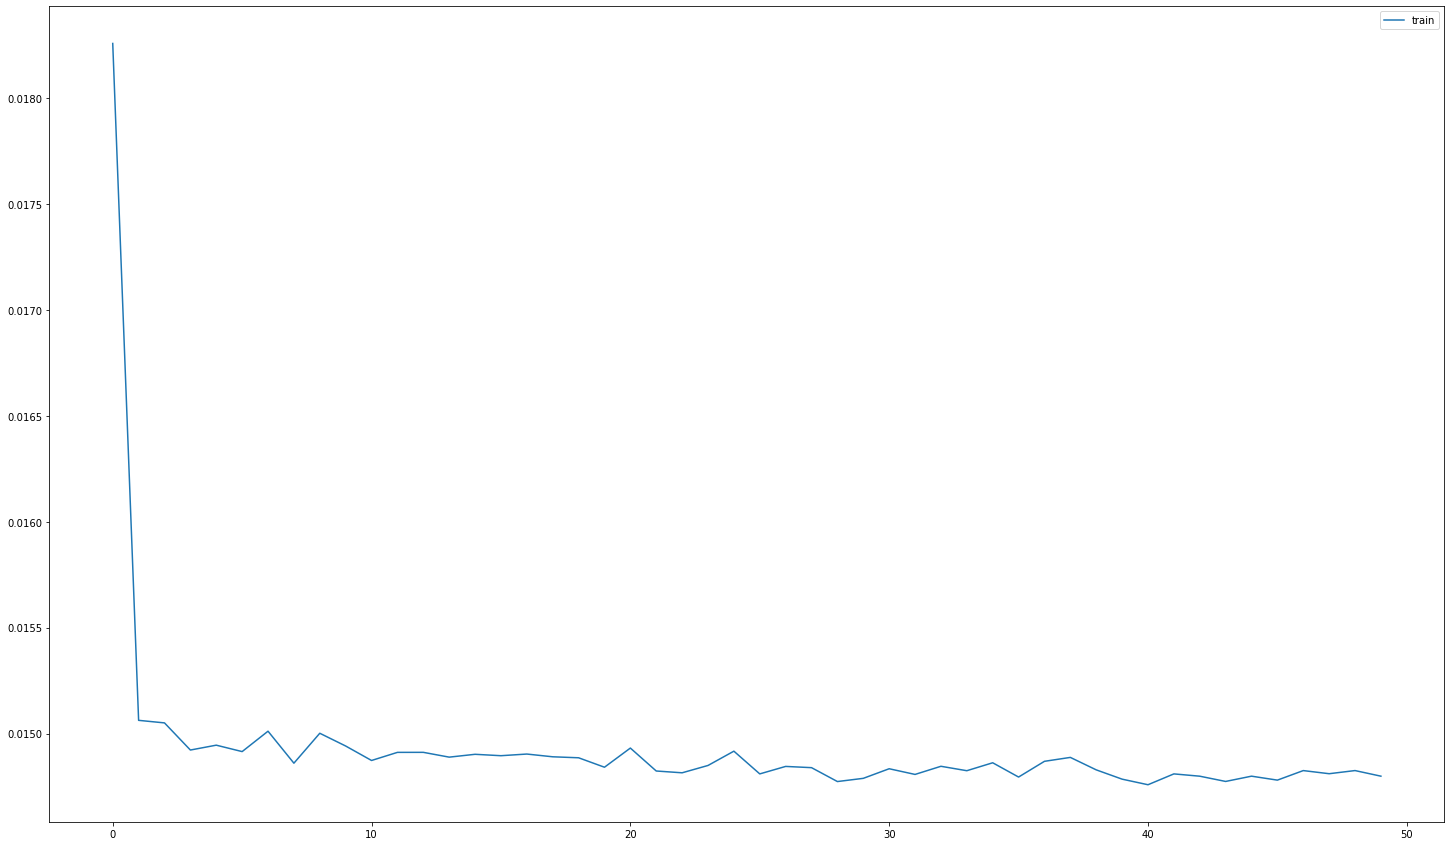

{'naive': 2.771548}


true      multi
0     3.545602   3.541541
1     5.656806   3.541541
2     5.656806   5.690451
3     8.528798   5.690451
4     8.528798   8.592161
...        ...        ...
2623  6.889673  11.083158
2624  6.889673   6.936340
2625  3.975907   6.936340
2626  3.975907   3.993259
2627  3.035914   3.993259

[2628 rows x 2 columns]

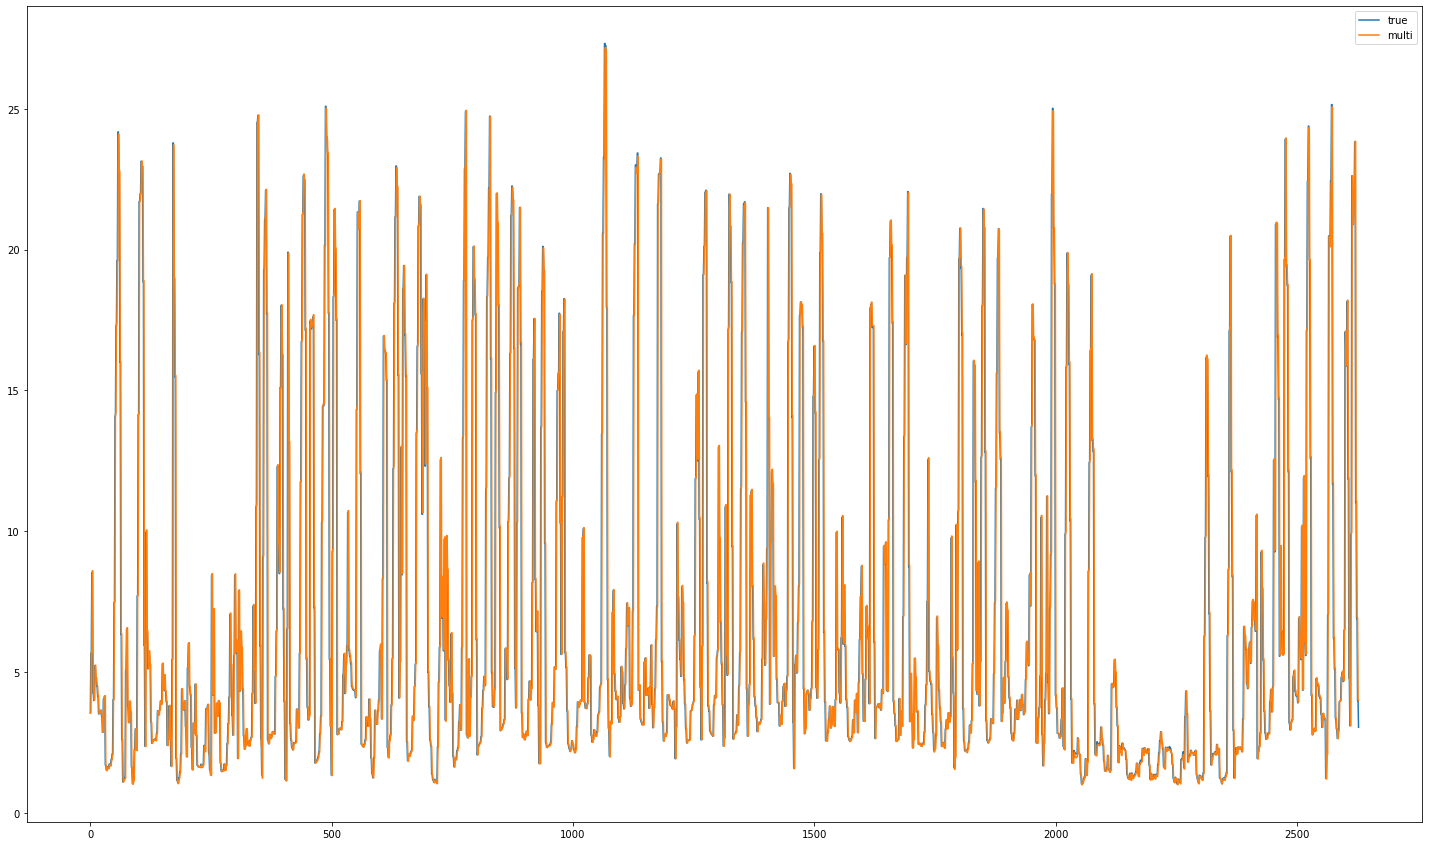

In [614]:
train_model(home_f)

# Training single LSTMS

In [7]:
first=homes['total_a'].first_valid_index()
last= homes['total_a'].last_valid_index()


In [8]:
sub_home = homes.loc[first:last,:]

<AxesSubplot:ylabel='Date & Time'>

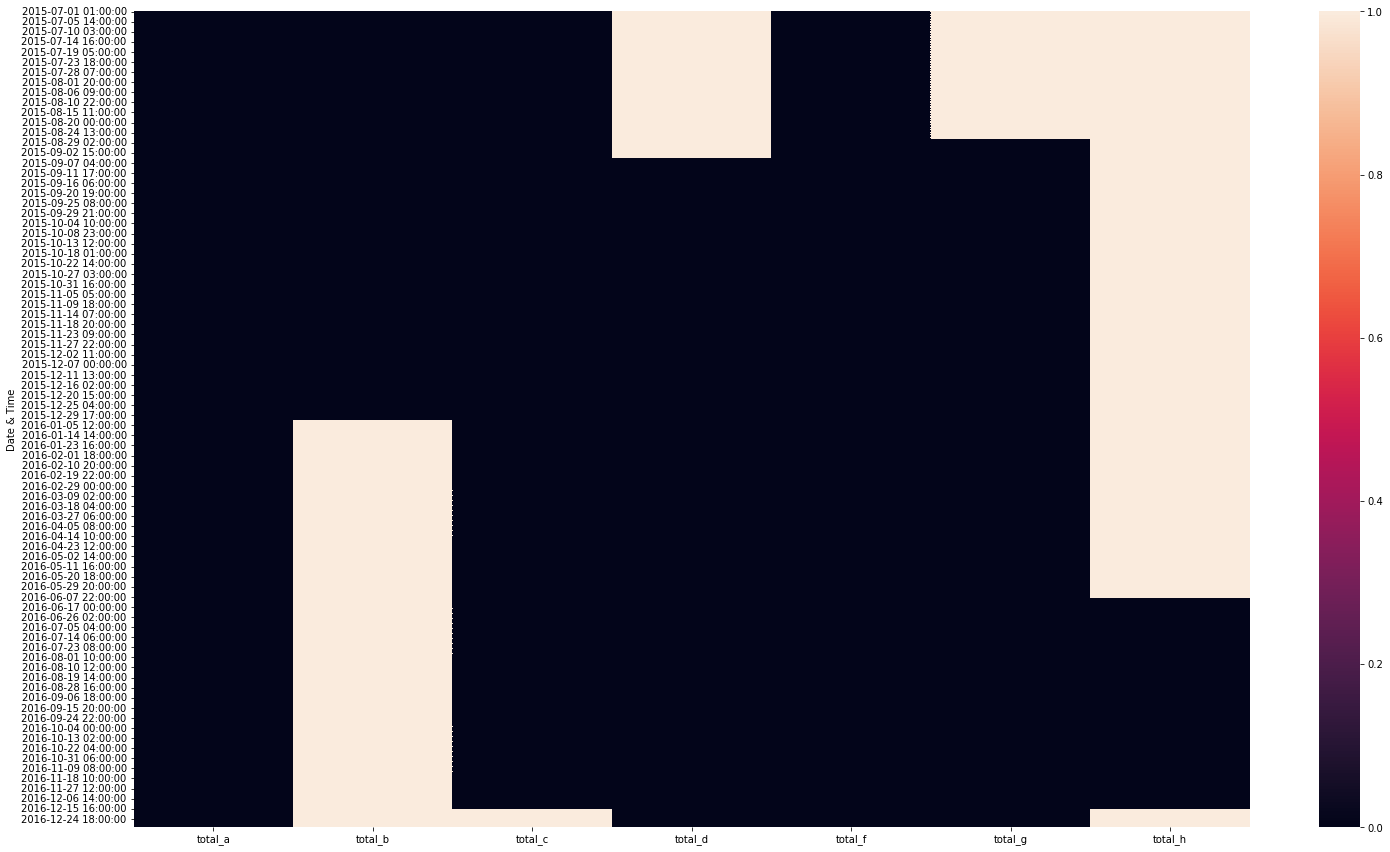

In [9]:
sns.heatmap(sub_home.isna())

In [10]:
a=len(sub_home['total_a'].dropna())
c= len(sub_home['total_c'].dropna())

b= len(sub_home['total_b'].dropna())
d = len(sub_home['total_d'].dropna())
f = len(sub_home['total_f'].dropna())
g = len(sub_home['total_g'].dropna())
h = len(sub_home['total_h'].dropna())


print(a, b,c, d,f,g,h)

17614 8830 17229 14446 17614 14846 4545


In [11]:
home_len=[a,b,c,d,f,g,h]
total_len = len(sub_home)

In [12]:
home_len

[17614, 8830, 17229, 14446, 17614, 14846, 4545]

In [13]:
for i in home_len:
    if (i/total_len)<0.8:
        print(" home %f is not viable"%i )

 home 8830.000000 is not viable
 home 4545.000000 is not viable


In [14]:
sub_home= sub_home.drop(['total_b', "total_h"],axis=1)

In [15]:
sub_home.dropna(inplace=True)

In [16]:
nonna =homes.notnull().sum()
nonna= nonna.values
nonna= nonna.tolist()
df_length= len(homes)
weights= [x/df_length for x in nonna]

In [17]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [18]:
energy= sub_home['total_a'].values
energy= energy.reshape(len(energy),1)
energy = energy.astype('float32')
print(energy.shape)


(14061, 1)


In [19]:
train, test = train_test_split(energy, train_size=0.8, shuffle=False)

In [20]:
# Scaling the data to the interval [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [24]:
timesteps = 1 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(11247, 1, 1)

### Vanilla LSTM

In [25]:
lstmmod = Sequential()
lstmmod.add(LSTM(256, return_sequences=True))
lstmmod.add(Dropout(0.2))
lstmmod.add(LSTM(256, return_sequences=False))
lstmmod.add(Dense(1))




In [26]:
lstmmod.compile(loss="mae", optimizer="adam", metrics=['mean_absolute_error'])

Epoch 1/50
157/157 - 6s - loss: 0.0490 - mean_absolute_error: 0.0490 - 6s/epoch - 35ms/step
Epoch 2/50
157/157 - 2s - loss: 0.0380 - mean_absolute_error: 0.0380 - 2s/epoch - 13ms/step
Epoch 3/50
157/157 - 2s - loss: 0.0376 - mean_absolute_error: 0.0376 - 2s/epoch - 14ms/step
Epoch 4/50
157/157 - 3s - loss: 0.0378 - mean_absolute_error: 0.0378 - 3s/epoch - 20ms/step
Epoch 5/50
157/157 - 2s - loss: 0.0378 - mean_absolute_error: 0.0378 - 2s/epoch - 15ms/step
Epoch 6/50
157/157 - 2s - loss: 0.0374 - mean_absolute_error: 0.0374 - 2s/epoch - 13ms/step
Epoch 7/50
157/157 - 2s - loss: 0.0377 - mean_absolute_error: 0.0377 - 2s/epoch - 13ms/step
Epoch 8/50
157/157 - 3s - loss: 0.0373 - mean_absolute_error: 0.0373 - 3s/epoch - 20ms/step
Epoch 9/50
157/157 - 3s - loss: 0.0375 - mean_absolute_error: 0.0375 - 3s/epoch - 19ms/step
Epoch 10/50
157/157 - 3s - loss: 0.0375 - mean_absolute_error: 0.0375 - 3s/epoch - 17ms/step
Epoch 11/50
157/157 - 3s - loss: 0.0373 - mean_absolute_error: 0.0373 - 3s/epoc

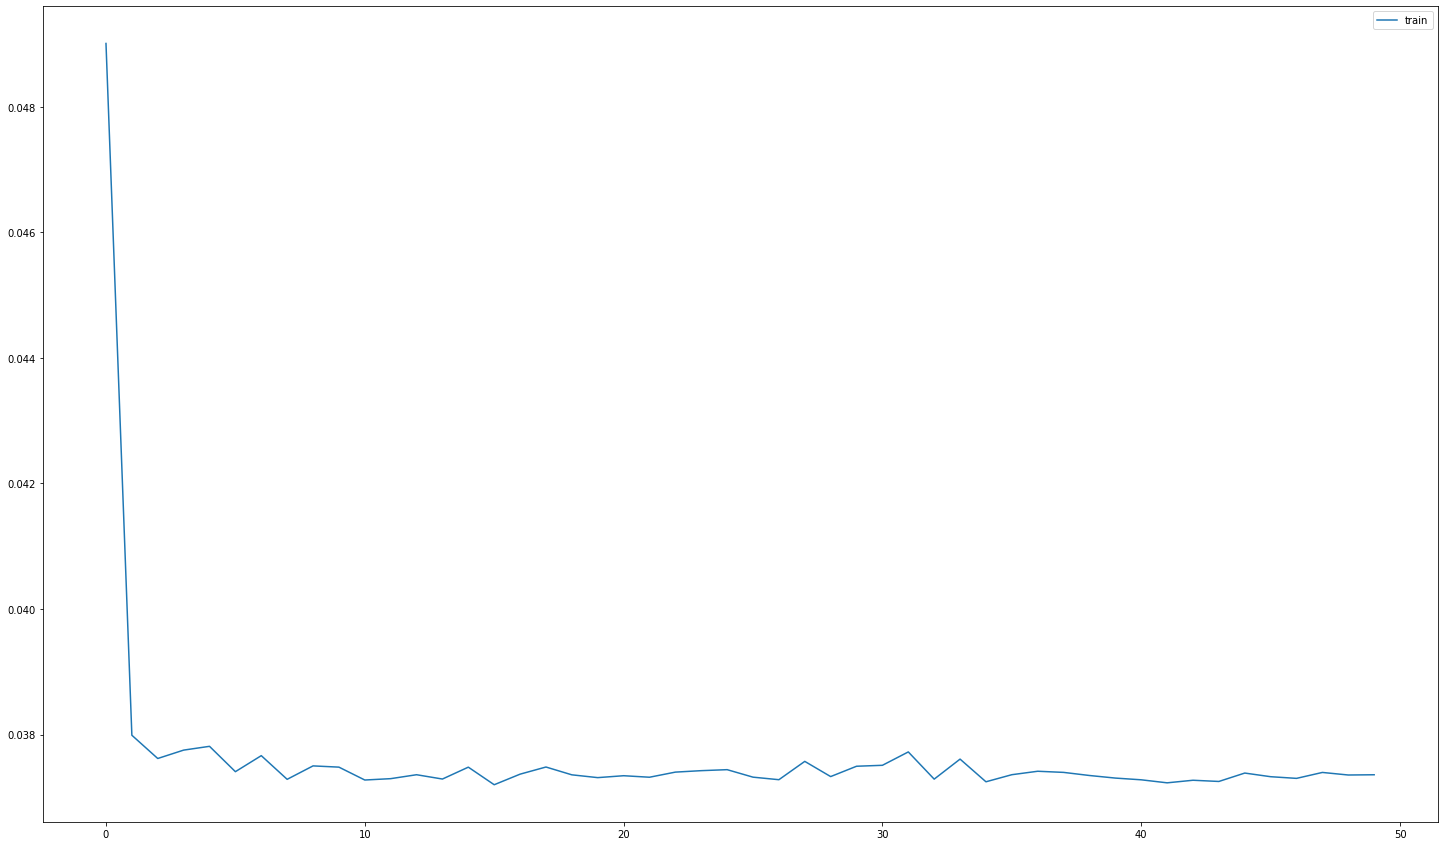

In [27]:
# fit network
history2 = lstmmod.fit(X_train, y_train,epochs=50, batch_size=72, verbose=2, shuffle=False)

# plot history
plt.plot(history2.history['loss'], label='train')
#plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

# #Predict model
# yhat= model.predict(X_test)
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# inv_yhat = np.concatenate((X_test, yhat), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat=inv_yhat[:,-1]
# #Invert scaling for actual 
# y_test = y_test.reshape(len(y_test),1)
# inv_y= np.concatenate((X_test, y_test), axis=1)
# inv_y = scaler.inverse_transform(inv_y)

# inv_y = inv_y[:,-1]

# def rmse(y_true, y_score):
#     error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
#     return error

# #pred_b_train= {}
# pred_b_test= {}

# pred_b_test['true'] = inv_y
# pred_b_test['multi'] = inv_yhat

# rmse_b_test["naive"]  = rmse(pred_b_test["true"],  pred_b_test["multi"])

# pred_b_test = pd.DataFrame(pred_b_test)
# print(rmse_b_test)

# pred_b_test.plot()

In [30]:
global_weights= lstmmod.get_weights()

In [36]:
#initial list to collect local model weights after scalling
scaled_local_weight_list = list()

In [50]:
homes

total_a   total_b   total_c   total_d   total_f  \
Date & Time                                                             
2014-01-01 00:00:00       NaN  1.676843  2.689820       NaN  2.060571   
2014-01-01 01:00:00       NaN  2.167156  1.518391       NaN  1.212912   
2014-01-01 02:00:00       NaN  1.102414  1.963862       NaN  1.342836   
2014-01-01 03:00:00       NaN  1.910317  2.223021       NaN  1.549448   
2014-01-01 04:00:00       NaN  1.479763  1.855156       NaN  2.604672   
...                       ...       ...       ...       ...       ...   
2016-12-31 19:00:00  0.177386       NaN       NaN  8.789098  1.479447   
2016-12-31 20:00:00  0.199725       NaN       NaN  8.362464  1.439440   
2016-12-31 21:00:00  0.222266       NaN       NaN  6.216546  1.410874   
2016-12-31 22:00:00  0.203904       NaN       NaN  6.726995  0.975436   
2016-12-31 23:00:00  0.196847       NaN       NaN  7.200723  0.576490   

                      total_g  total_h  
Date & Time                             
2014-01-01 00:00:00       NaN      NaN  
2014-01-01 01:00:00       NaN      NaN  
2014-01-01 02:00:00       NaN      NaN  
2014-01-01 03:00:00       NaN      NaN  
2014-01-01 04:00:00       NaN      NaN  
...                       ...      ...  
2016-12-31 19:00:00  0.669979      NaN  
2016-12-31 20:00:00  0.234510      NaN  
2016-12-31 21:00:00  0.278918      NaN  
2016-12-31 22:00:00  0.106219      NaN  
2016-12-31 23:00:00  0.106472      NaN  

[35064 rows x 7 columns]

In [101]:
def run_model(home: pd.Series, train_size, timesteps= 1, epochs=50, batch_size= 64):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

    #Define the model
    model = Sequential()
    model.add(LSTM(256))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    
    pred_train ={}
    pred_test = {}

    rmse_train ={}
    rmse_test = {}

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train["simple_lstm"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #plot the predictions
    plt.plot(pred_test['true'])
    plt.plot(pred_test['simple_lstm'])
    plt.show()


    rmse_test['single'] = rmse(pred_test['true'], pred_test['simple_lstm'])
    rmse_train['single'] = rmse(pred_train['true'], pred_train['simple_lstm'])

  
    print(f"The RMSE in the train set is: {rmse_train['single']}")
    print(f"The RMSE in the test set is: {rmse_test['single']}")


    return pred_train, pred_test

    


    

(15851, 1, 1)
Epoch 1/50
248/248 - 4s - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0061 - val_mse: 0.0061 - 4s/epoch - 16ms/step
Epoch 2/50
248/248 - 1s - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 6ms/step
Epoch 3/50
248/248 - 2s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 2s/epoch - 6ms/step
Epoch 4/50
248/248 - 2s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 2s/epoch - 7ms/step
Epoch 5/50
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 985ms/epoch - 4ms/step
Epoch 6/50
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 979ms/epoch - 4ms/step
Epoch 7/50
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0060 - val_mse: 0.0060 - 961ms/epoch - 4ms/step
Epoch 8/50
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0060 - val_mse: 0.0060 - 961ms/epoch - 4ms/step
Epoch 9/50
248/248 - 1s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0060 - val

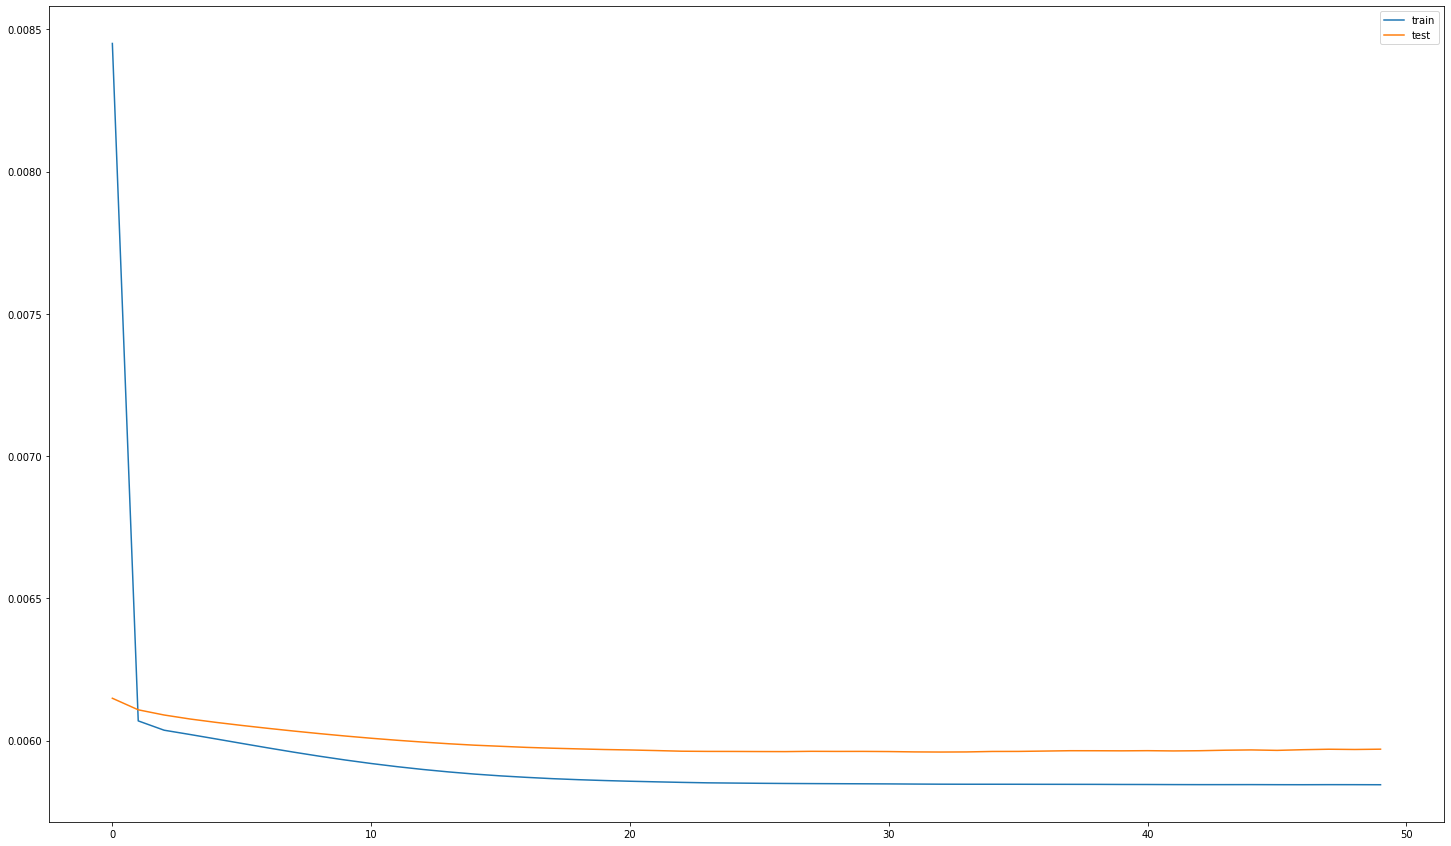

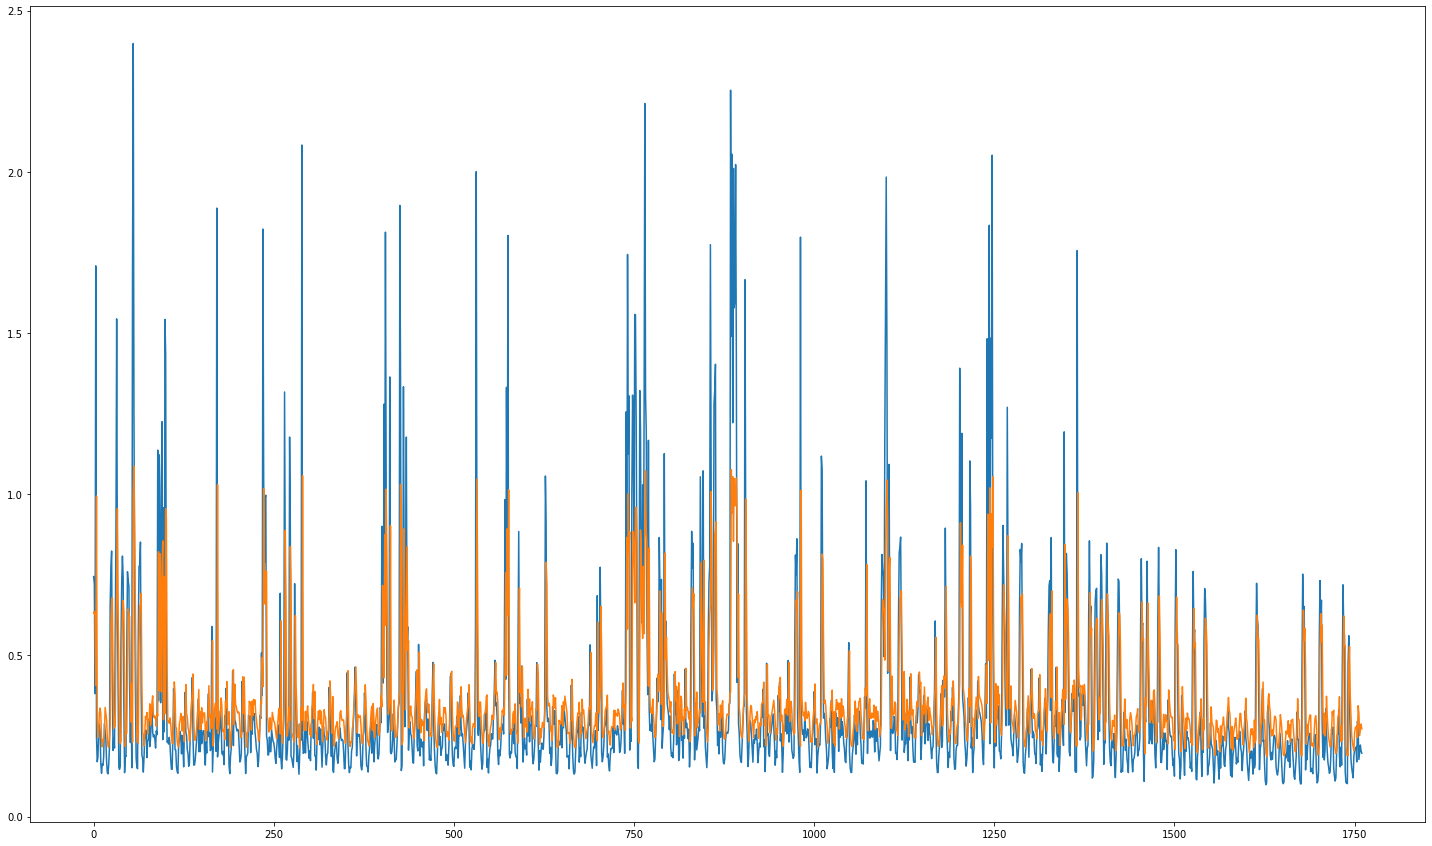

The RMSE in the train set is: 0.2477104725854923
The RMSE in the test set is: 0.2477104725854923


({'true': array([0.20871028, 0.19131055, 0.19131055, ..., 0.16343917, 0.16412778,
         0.50583194]),
  'simple_lstm': array([0.27664557, 0.27664557, 0.26270908, ..., 0.23429225, 0.24007644,
         0.24064022], dtype=float32)},
 {'true': array([0.74465028, 0.72244861, 0.38161333, ..., 0.22226583, 0.20390444,
         0.19684667]),
  'simple_lstm': array([0.6316848 , 0.636406  , 0.62405413, ..., 0.26946738, 0.2874007 ,
         0.27281103], dtype=float32)})

In [71]:
run_model(homes['total_a'], train_size=0.9, timesteps=1, epochs=50, batch_size=64)

(23651, 1, 1)
Epoch 1/50
370/370 - 4s - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0013 - val_mse: 0.0013 - 4s/epoch - 11ms/step
Epoch 2/50
370/370 - 2s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 3/50
370/370 - 2s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 7/50
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 8/50
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 9/50
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013

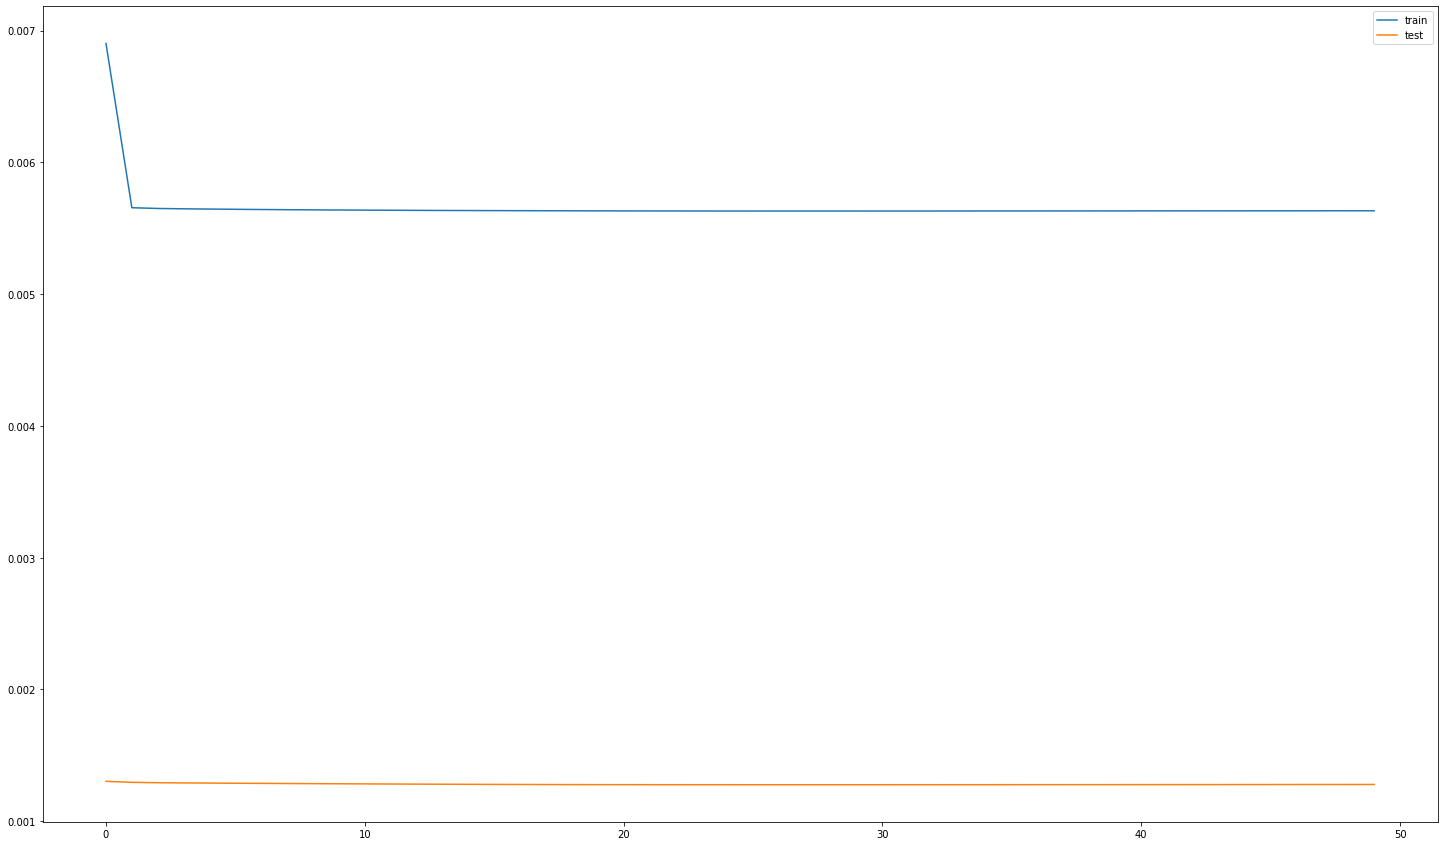

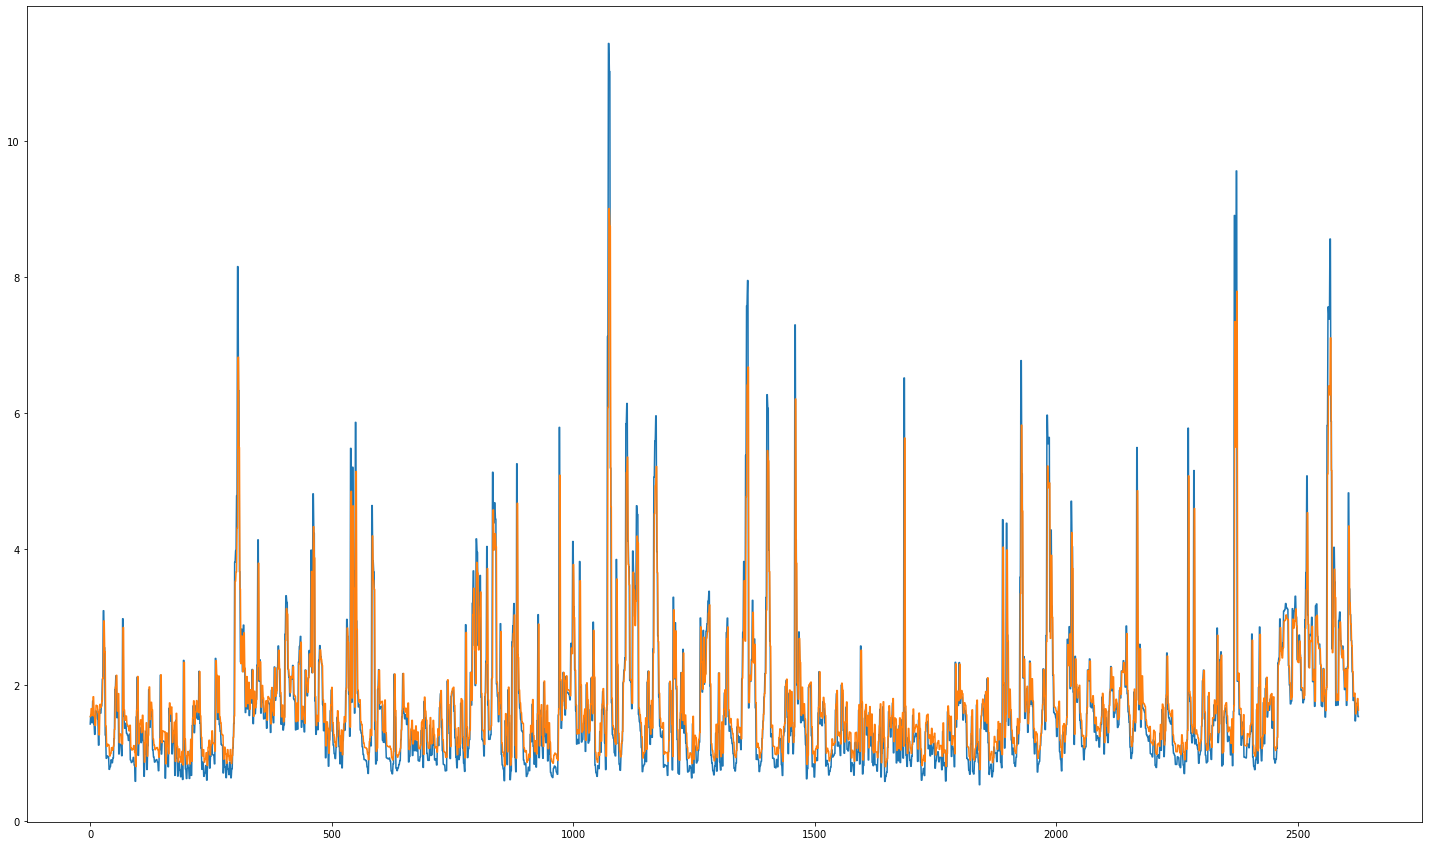

The RMSE in the train set is: 1.412710956568152
The RMSE in the test set is: 0.6679917412225992


({'true': array([2.16715639, 1.10241389, 1.91031722, ..., 1.88347917, 1.62950778,
         1.62950778]),
  'simple_lstm': array([1.7516681, 2.1694422, 1.2553936, ..., 1.928391 , 1.928391 ,
         1.7110503], dtype=float32)},
 {'true': array([1.42762833, 1.56321583, 1.56321583, ..., 1.73631806, 1.53719889,
         1.53719889]),
  'simple_lstm': array([1.5372608, 1.5372608, 1.6540825, ..., 1.802631 , 1.802631 ,
         1.6316981], dtype=float32)})

In [73]:
run_model(homes['total_b'], train_size=0.9)

(27742, 1, 1)
Epoch 1/50
434/434 - 5s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041 - 5s/epoch - 11ms/step
Epoch 2/50
434/434 - 2s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0041 - val_mse: 0.0041 - 2s/epoch - 6ms/step
Epoch 3/50
434/434 - 3s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0041 - val_mse: 0.0041 - 3s/epoch - 7ms/step
Epoch 4/50
434/434 - 3s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0041 - val_mse: 0.0041 - 3s/epoch - 6ms/step
Epoch 5/50
434/434 - 2s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0041 - val_mse: 0.0041 - 2s/epoch - 5ms/step
Epoch 6/50
434/434 - 3s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0041 - val_mse: 0.0041 - 3s/epoch - 7ms/step
Epoch 7/50
434/434 - 3s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0041 - val_mse: 0.0041 - 3s/epoch - 7ms/step
Epoch 8/50
434/434 - 3s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0041 - val_mse: 0.0041 - 3s/epoch - 8ms/step
Epoch 9/50
434/434 - 3s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0041 - val_mse: 0.0041

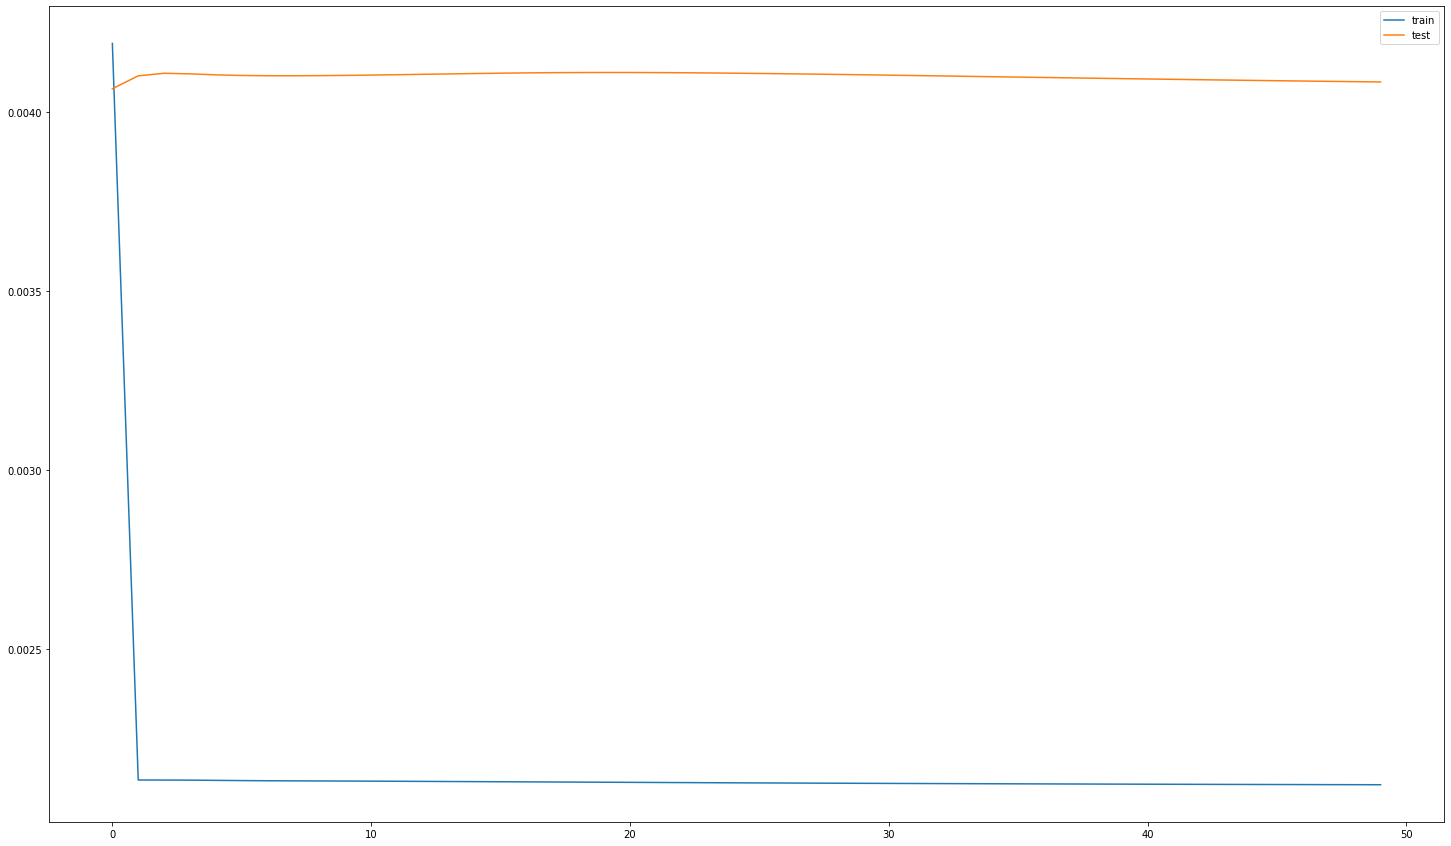

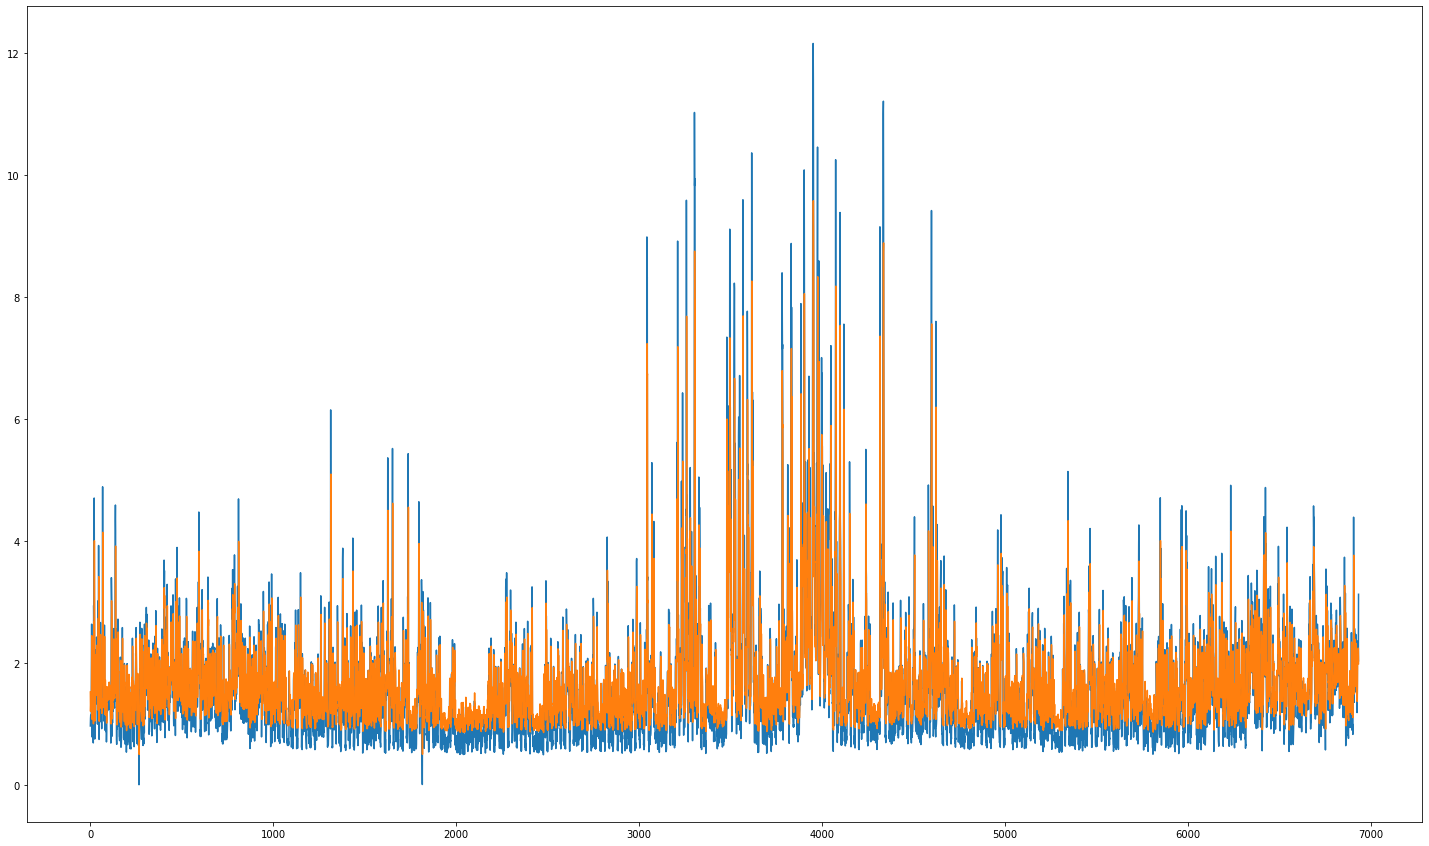

({'true': array([1.51839083, 1.96386195, 2.22302139, ..., 2.22512861, 1.65216417,
         1.53370389]),
  'simple_lstm': array([2.486174 , 1.6134537, 1.9442841, ..., 2.3856907, 2.1389372,
         1.7126534], dtype=float32)},
 {'true': array([0.96402778, 1.09015139, 1.13939833, ..., 2.354205  , 2.02097639,
         3.12495722]),
  'simple_lstm': array([1.5220466, 1.2038223, 1.296803 , ..., 2.2407625, 2.2352617,
         1.9867988], dtype=float32)})

In [58]:
run_model(homes['total_c'], train_size=0.8)

(11555, 1, 1)
Epoch 1/50
181/181 - 3s - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0082 - val_mse: 0.0082 - 3s/epoch - 15ms/step
Epoch 2/50
181/181 - 1s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0082 - val_mse: 0.0082 - 816ms/epoch - 5ms/step
Epoch 3/50
181/181 - 1s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0082 - val_mse: 0.0082 - 825ms/epoch - 5ms/step
Epoch 4/50
181/181 - 1s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0082 - val_mse: 0.0082 - 807ms/epoch - 4ms/step
Epoch 5/50
181/181 - 1s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0082 - val_mse: 0.0082 - 964ms/epoch - 5ms/step
Epoch 6/50
181/181 - 1s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0083 - val_mse: 0.0083 - 854ms/epoch - 5ms/step
Epoch 7/50
181/181 - 1s - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0083 - val_mse: 0.0083 - 1s/epoch - 6ms/step
Epoch 8/50
181/181 - 1s - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0083 - val_mse: 0.0083 - 1s/epoch - 7ms/step
Epoch 9/50
181/181 - 1s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0083 - 

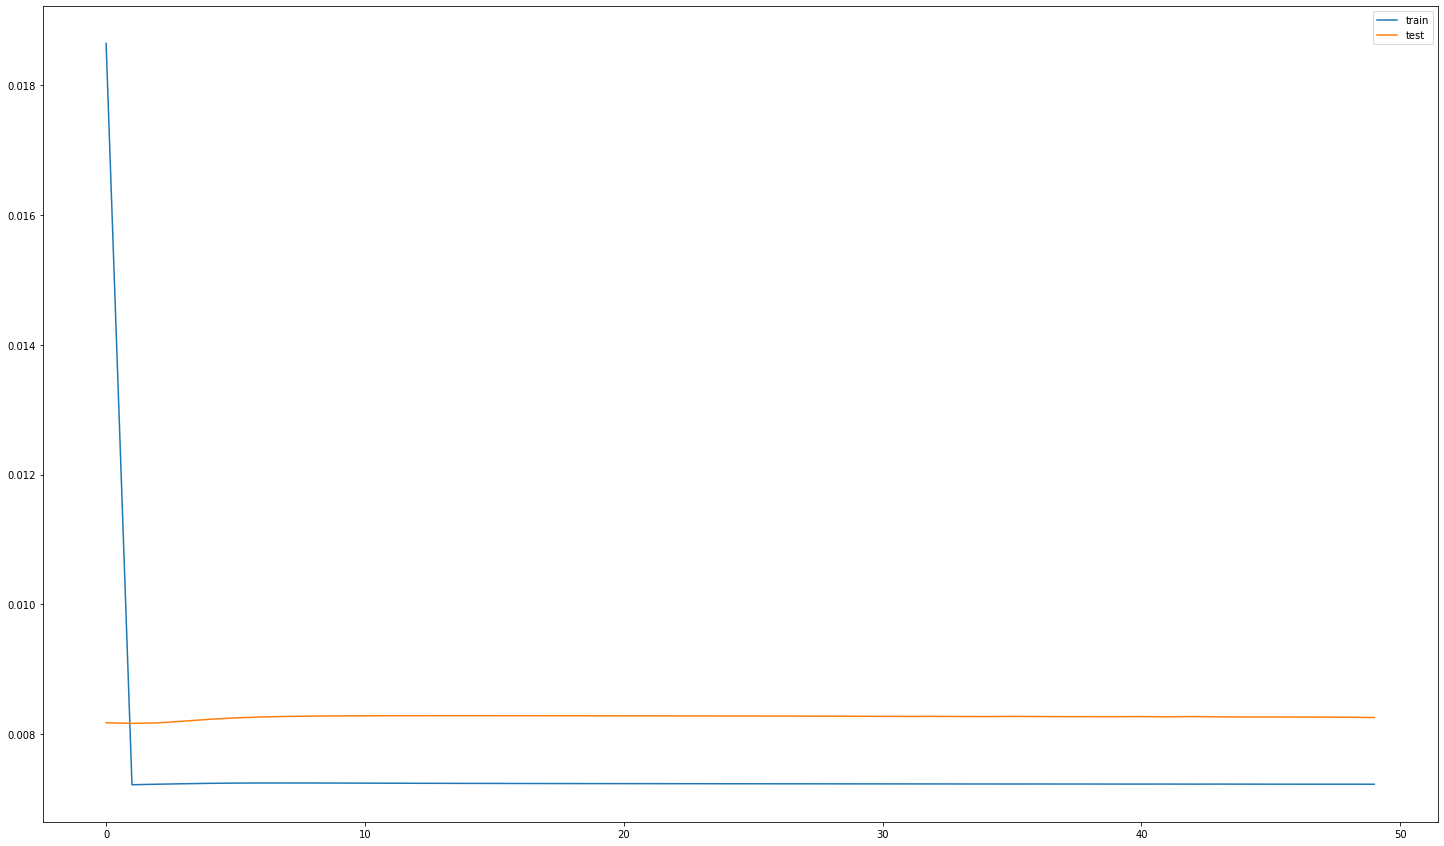

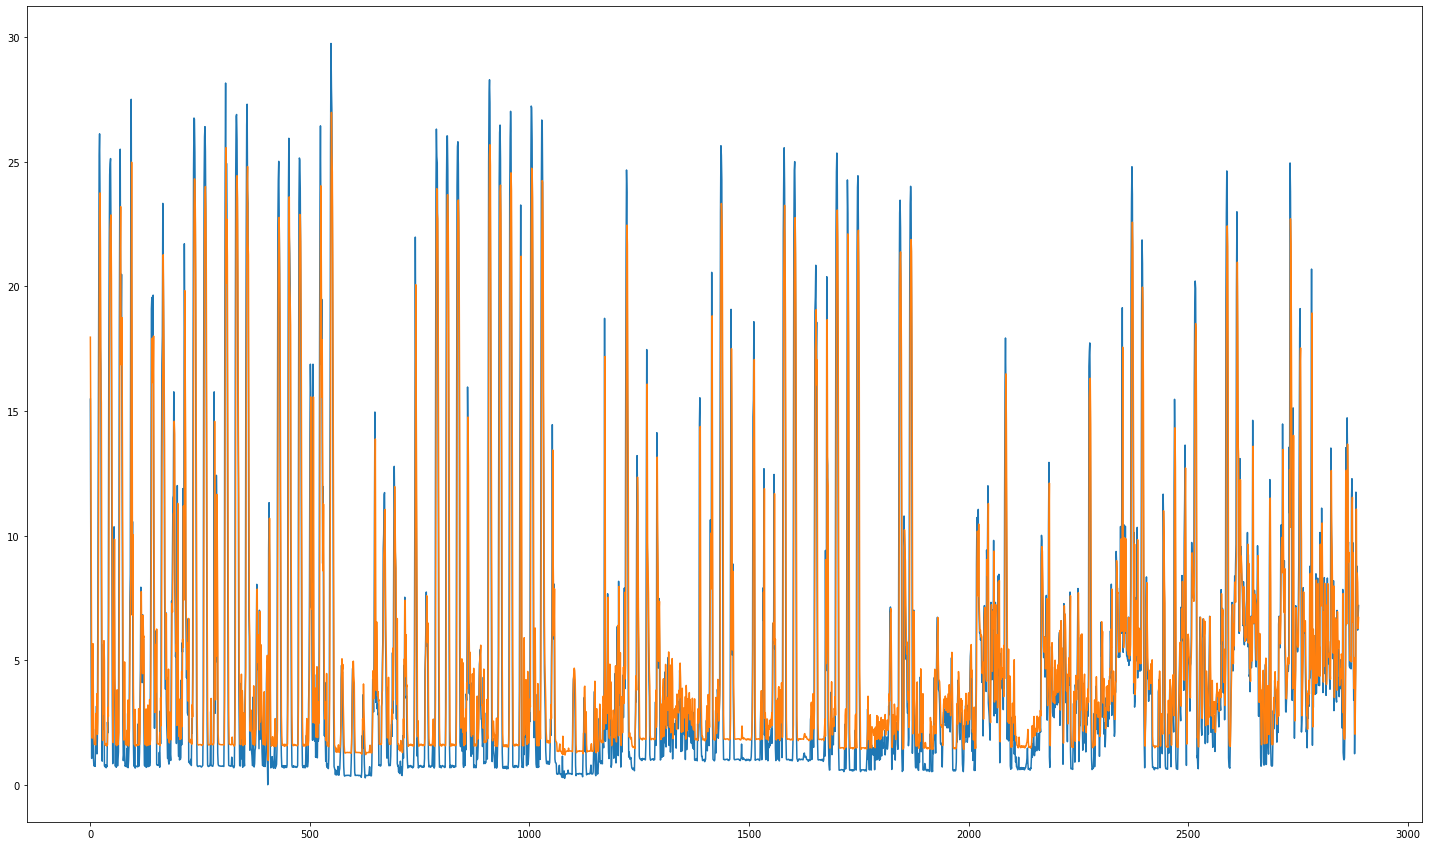

({'true': array([ 0.74534166,  0.79690861,  0.79690861, ..., 23.39730556,
         26.56645083, 23.67150528]),
  'simple_lstm': array([ 1.6078615,  1.6078615,  1.6515201, ..., 19.22331  , 21.330038 ,
         24.147943 ], dtype=float32)},
 {'true': array([15.47960333,  9.05739861,  3.67922722, ...,  6.21654611,
          6.72699472,  7.20072278]),
  'simple_lstm': array([17.966528, 14.335268,  8.731211, ...,  8.129547,  6.278246,
          6.717685], dtype=float32)})

In [59]:
run_model(homes['total_d'], train_size=0.8)

(31556, 1, 1)
Epoch 1/50
494/494 - 7s - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0013 - val_mse: 0.0013 - 7s/epoch - 14ms/step
Epoch 2/50
494/494 - 2s - loss: 8.6085e-04 - mse: 8.6085e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 3/50
494/494 - 2s - loss: 8.6036e-04 - mse: 8.6036e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 4/50
494/494 - 2s - loss: 8.5860e-04 - mse: 8.5860e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 5/50
494/494 - 2s - loss: 8.5660e-04 - mse: 8.5660e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 6/50
494/494 - 3s - loss: 8.5465e-04 - mse: 8.5465e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 3s/epoch - 5ms/step
Epoch 7/50
494/494 - 2s - loss: 8.5278e-04 - mse: 8.5278e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 8/50
494/494 - 2s - loss: 8.5103e-04 - mse: 8.5103e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 9/50
494/494 - 2s - loss: 8

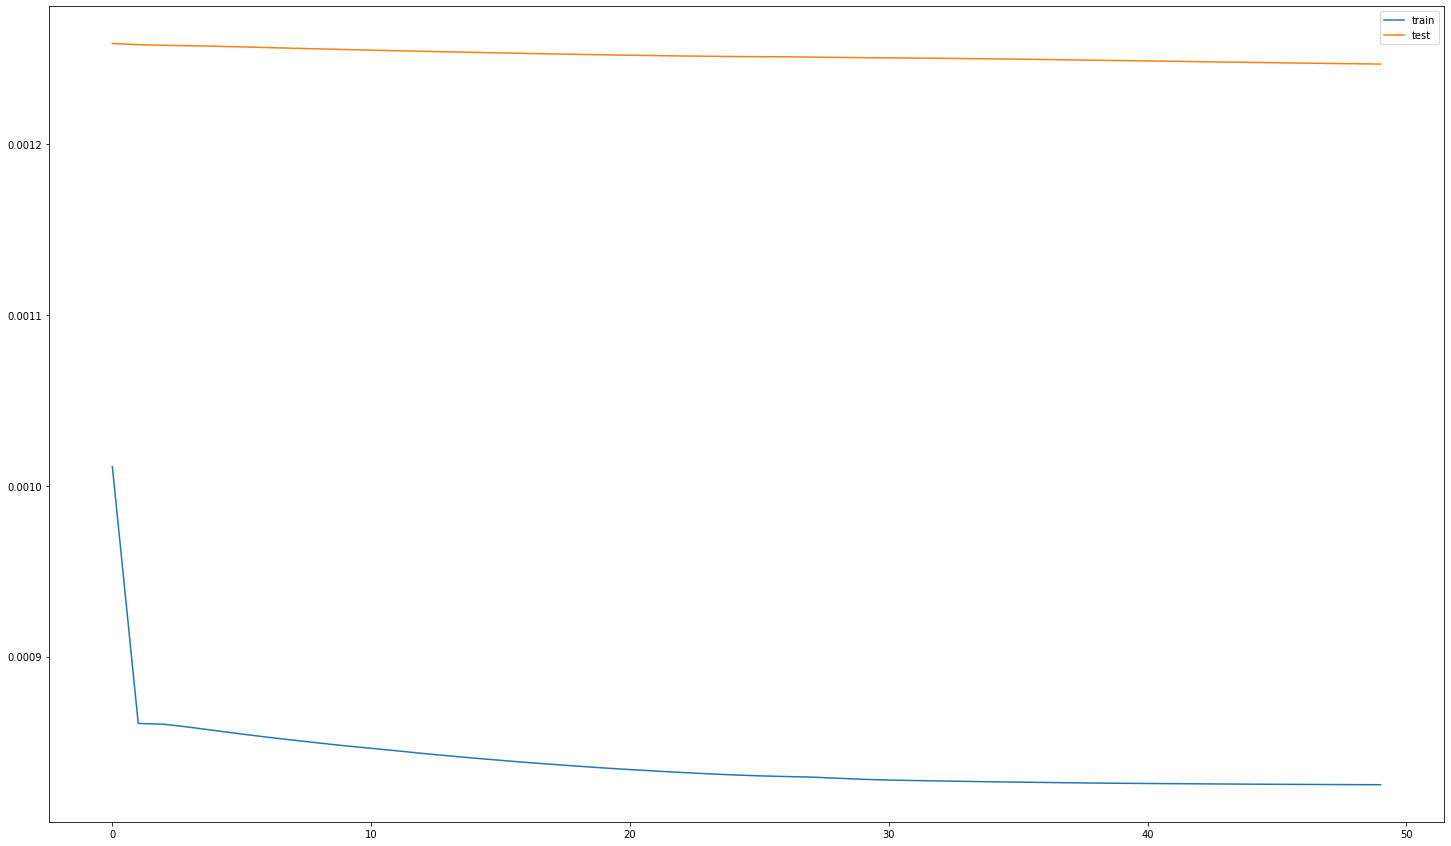

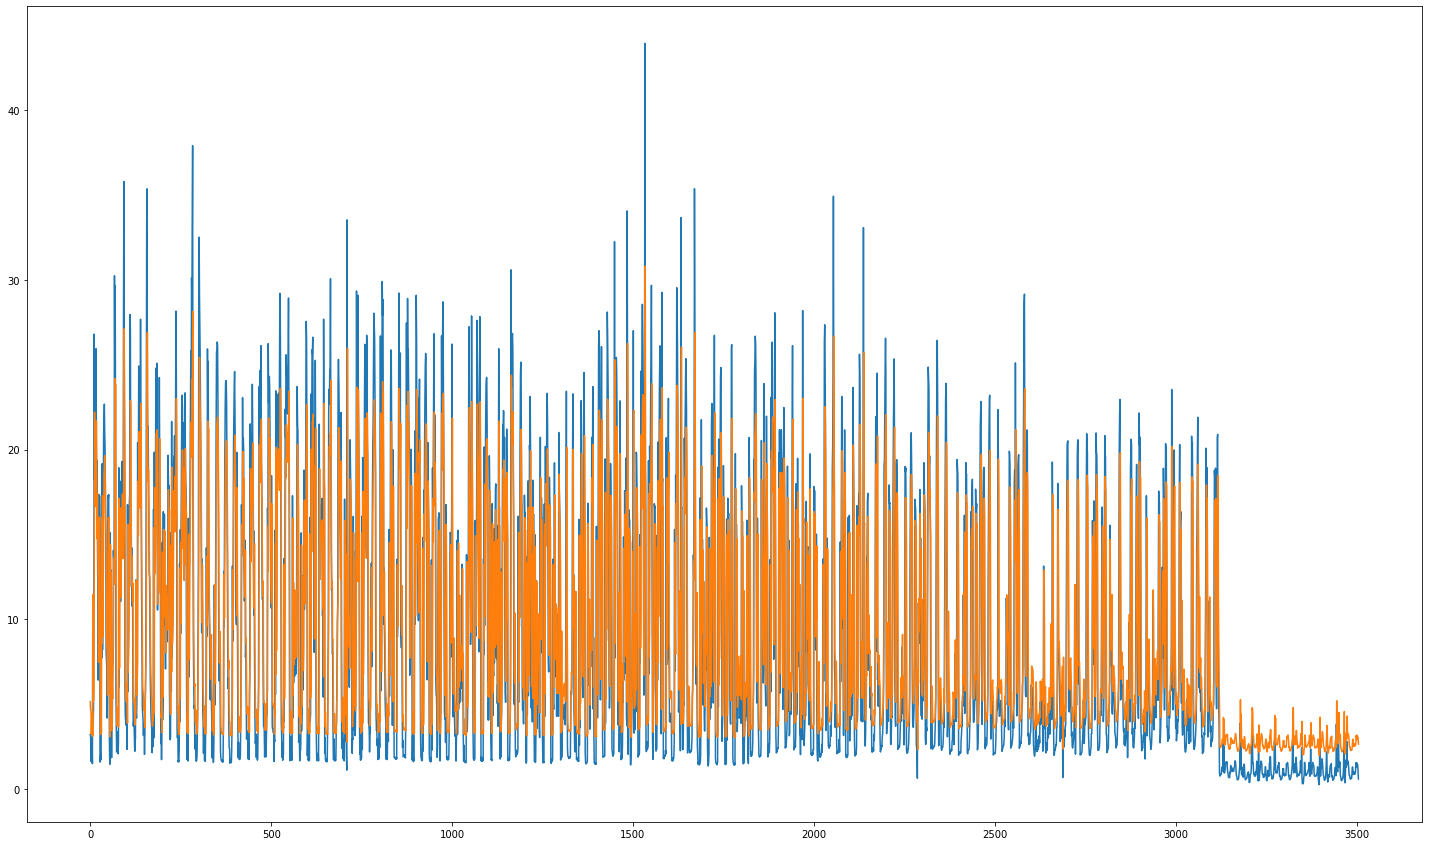

({'true': array([1.21291167, 1.34283583, 1.54944833, ..., 6.76781222, 5.44330972,
         6.95469556]),
  'simple_lstm': array([ 3.63183  ,  2.854979 ,  2.9746826, ..., 10.85085  ,  7.7699785,
          6.635534 ], dtype=float32)},
 {'true': array([3.20056861, 3.19068972, 1.6219925 , ..., 1.41087444, 0.97543611,
         0.57649028]),
  'simple_lstm': array([5.1384764, 4.66127  , 4.6524253, ..., 3.0635386, 3.0372775,
         2.6355915], dtype=float32)})

In [60]:
run_model(homes['total_f'], train_size=0.9)

(13360, 1, 1)
Epoch 1/30
209/209 - 4s - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0164 - val_mse: 0.0164 - 4s/epoch - 19ms/step
Epoch 2/30
209/209 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0132 - val_mse: 0.0132 - 1s/epoch - 6ms/step
Epoch 3/30
209/209 - 1s - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0114 - val_mse: 0.0114 - 1s/epoch - 5ms/step
Epoch 4/30
209/209 - 1s - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0105 - val_mse: 0.0105 - 928ms/epoch - 4ms/step
Epoch 5/30
209/209 - 1s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0101 - val_mse: 0.0101 - 1s/epoch - 5ms/step
Epoch 6/30
209/209 - 2s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0100 - val_mse: 0.0100 - 2s/epoch - 7ms/step
Epoch 7/30
209/209 - 1s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0099 - val_mse: 0.0099 - 1000ms/epoch - 5ms/step
Epoch 8/30
209/209 - 1s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0098 - val_mse: 0.0098 - 916ms/epoch - 4ms/step
Epoch 9/30
209/209 - 1s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0098 - val_m

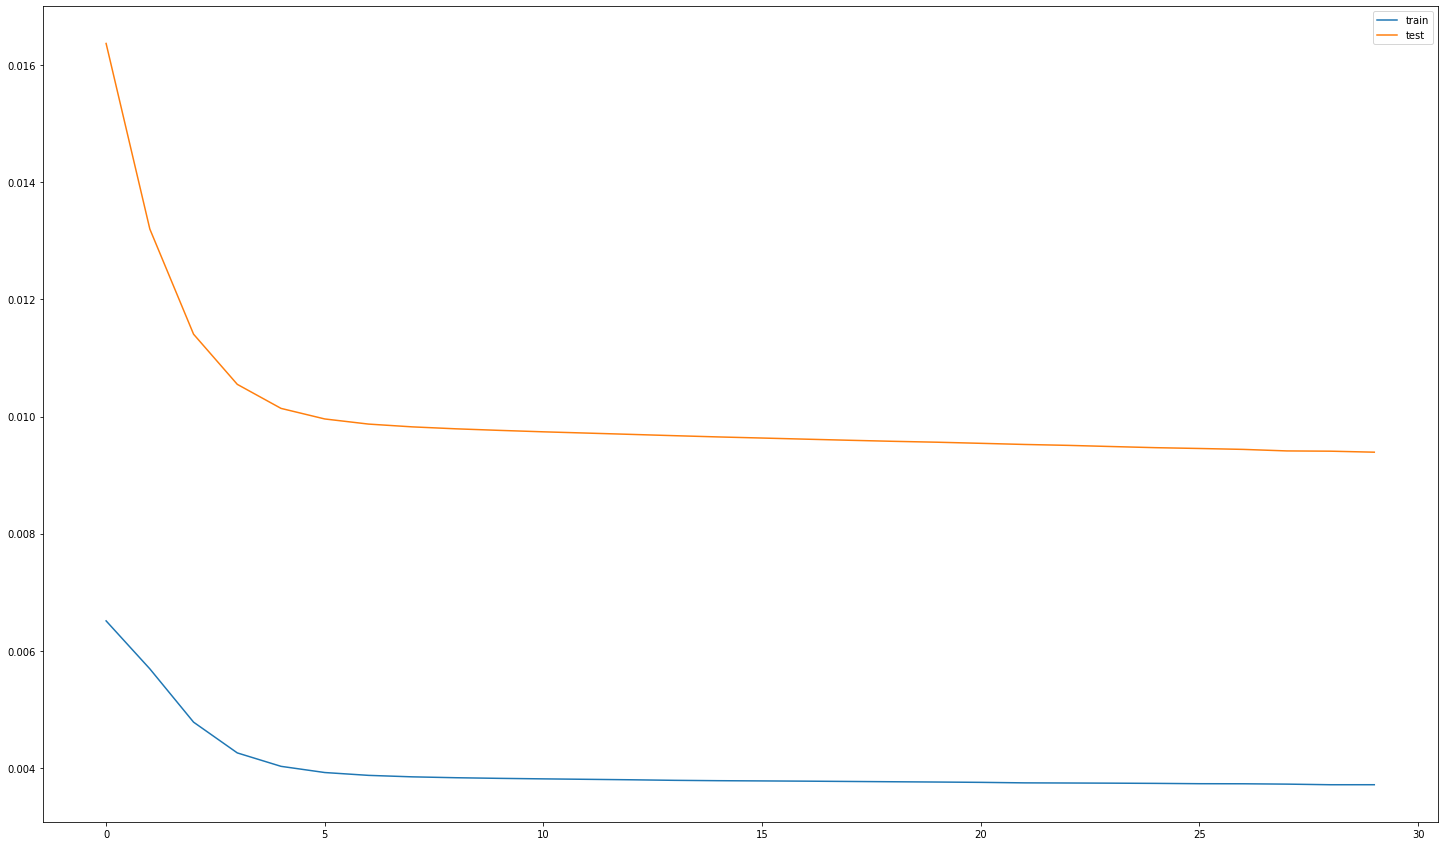

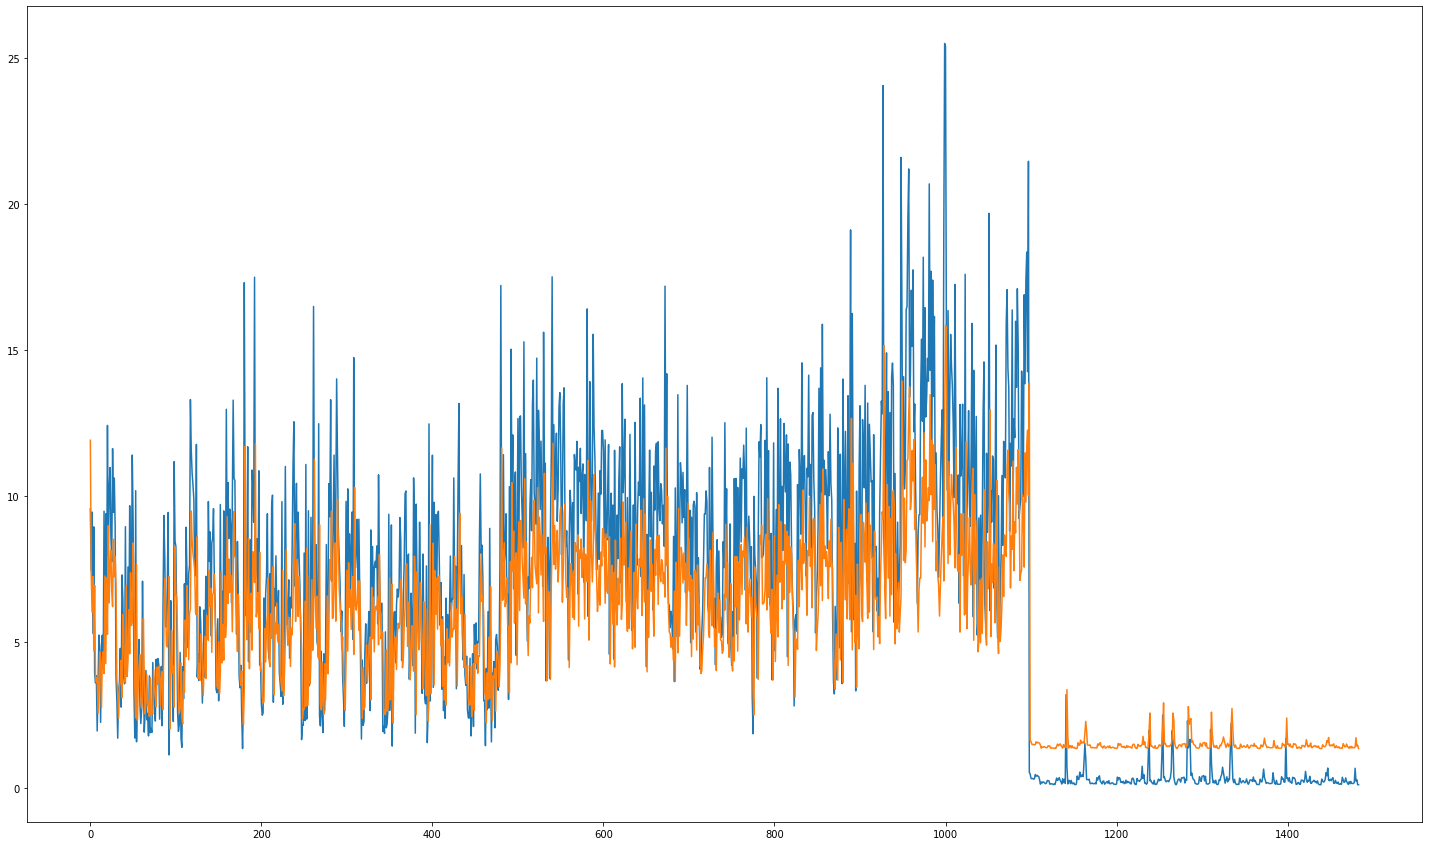

({'true': array([2.27194500e-03, 0.00000000e+00, 0.00000000e+00, ...,
         5.94143750e+00, 4.79679111e+00, 1.75482778e+00]),
  'simple_lstm': array([1.2766242, 1.2766242, 1.2751144, ..., 3.270996 , 5.1000957,
         4.382664 ], dtype=float32)},
 {'true': array([9.55569278, 7.43280361, 9.44724472, ..., 0.27891833, 0.10621889,
         0.10647194]),
  'simple_lstm': array([11.902974 ,  7.3028283,  6.0206103, ...,  1.4307668,  1.4601995,
          1.3456622], dtype=float32)})

In [61]:
run_model(homes['total_g'], train_size=0.9, epochs=30)

(13360, 1, 1)
Epoch 1/50
209/209 - 4s - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0168 - val_mse: 0.0168 - 4s/epoch - 17ms/step
Epoch 2/50
209/209 - 1s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0134 - val_mse: 0.0134 - 1s/epoch - 6ms/step
Epoch 3/50
209/209 - 1s - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0115 - val_mse: 0.0115 - 1s/epoch - 6ms/step
Epoch 4/50
209/209 - 1s - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0106 - val_mse: 0.0106 - 1s/epoch - 5ms/step
Epoch 5/50
209/209 - 1s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0101 - val_mse: 0.0101 - 952ms/epoch - 5ms/step
Epoch 6/50
209/209 - 1s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0100 - val_mse: 0.0100 - 943ms/epoch - 5ms/step
Epoch 7/50
209/209 - 1s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0099 - val_mse: 0.0099 - 911ms/epoch - 4ms/step
Epoch 8/50
209/209 - 1s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0098 - val_mse: 0.0098 - 1s/epoch - 6ms/step
Epoch 9/50
209/209 - 1s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0098 - val_ms

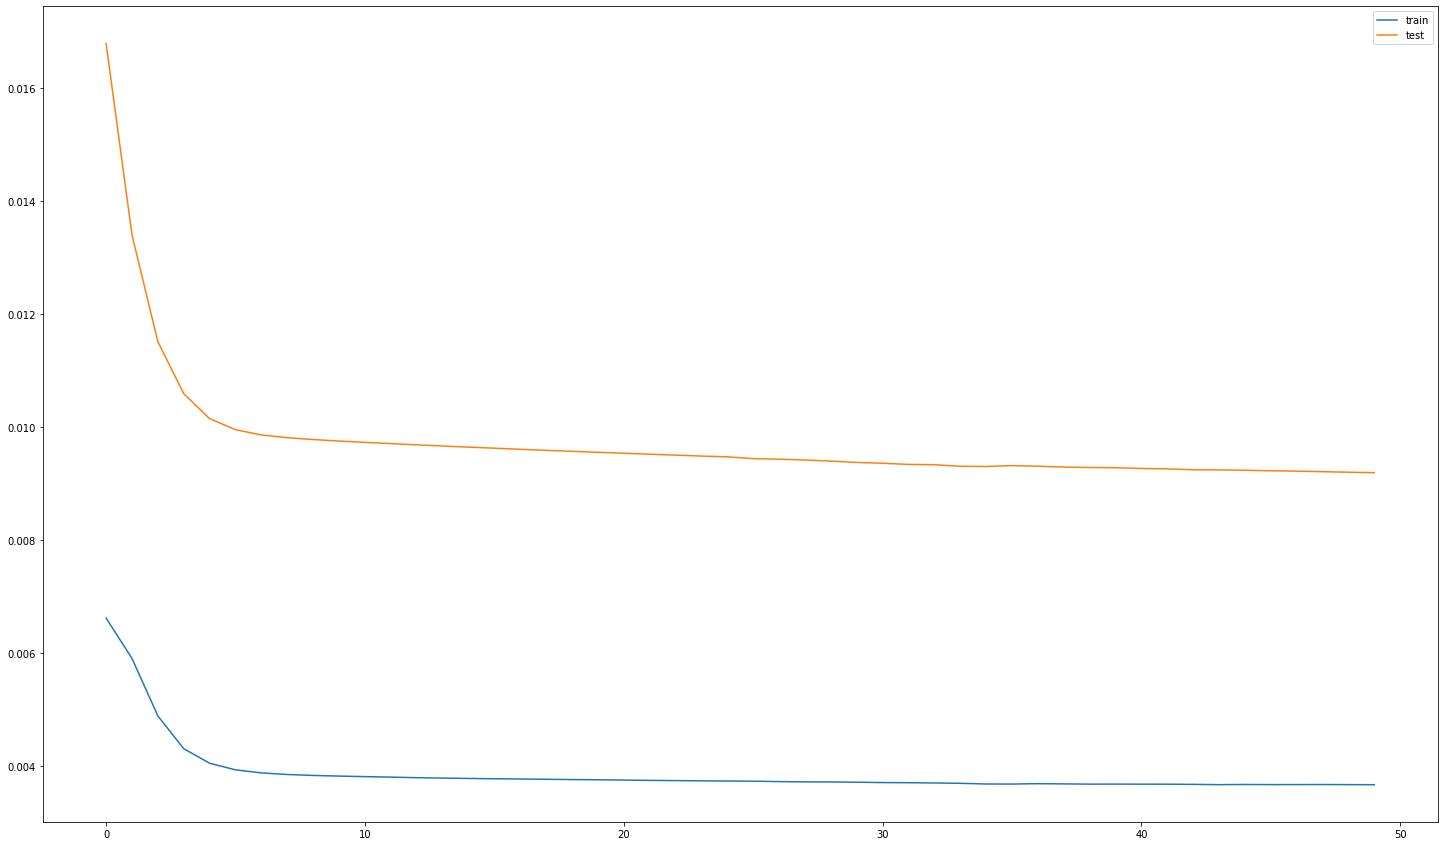

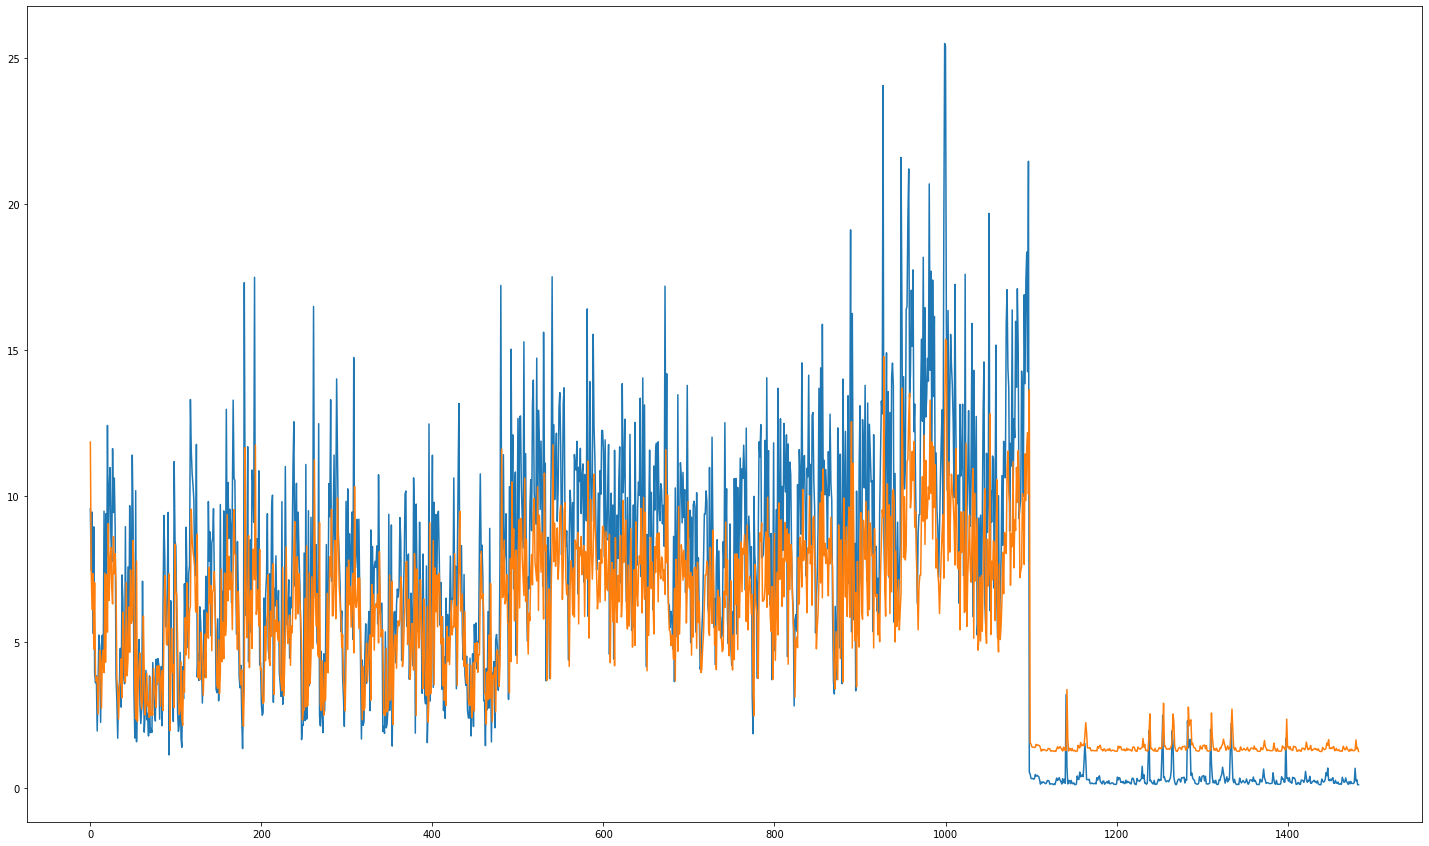

({'true': array([2.27194500e-03, 0.00000000e+00, 0.00000000e+00, ...,
         5.94143750e+00, 4.79679111e+00, 1.75482778e+00]),
  'simple_lstm': array([1.1710657, 1.1710657, 1.1694585, ..., 3.2753375, 5.169567 ,
         4.4309087], dtype=float32)},
 {'true': array([9.55569278, 7.43280361, 9.44724472, ..., 0.27891833, 0.10621889,
         0.10647194]),
  'simple_lstm': array([11.8432665,  7.3997507,  6.1087017, ...,  1.3350476,  1.3663341,
          1.2445375], dtype=float32)})

In [62]:
run_model(homes['total_g'], train_size=0.9)

### Convolutional LSTM

In [76]:
def run_conv_model(home: pd.Series, train_size, timesteps= 1, epochs=50, batch_size= 64):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

   

    conv = Sequential()
    conv.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    conv.add(MaxPooling1D(pool_size=2))
    conv.add(Flatten())
    conv.add(Dense(50, activation='relu'))
    conv.add(Dense(1))
    conv.compile(optimizer='adam', loss='mse')

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    
    pred_train ={}
    pred_test = {}

    rmse_train ={}
    rmse_test = {}

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train["simple_lstm"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #plot the predictions
    plt.plot(pred_test['true'])
    plt.plot(pred_test['simple_lstm'])
    plt.show()


    rmse_test['single'] = rmse(pred_test['true'], pred_test['simple_lstm'])
    rmse_train['single'] = rmse(pred_train['true'], pred_train['simple_lstm'])

  
    print(f"The RMSE in the train set is: {rmse_train['single']}")
    print(f"The RMSE in the test set is: {rmse_test['single']}")


    return pred_train, pred_test

    


    

In [168]:
#Drop nan values
home = homes['total_a']
home= home.dropna()

# train, test split
# split into train and test sets
values = home.values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.9, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
print(X_train.shape, X_test.shape)

(15851, 1, 1) (1761, 1, 1)


In [83]:
conv = Sequential()
conv.add(Conv1D(filters=64, kernel_size=2, activation='relu'))#, input_shape=(X_train.shape[1], X_train.shape[2])))
conv.add(MaxPooling1D(pool_size=2))
conv.add(Flatten())
conv.add(Dense(50, activation='relu'))
conv.add(Dense(1))
conv.compile(optimizer='adam', loss='mse')

In [85]:
#Fit the data
history= conv.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)

pred_train ={}
pred_test = {}

rmse_train ={}
rmse_test = {}

def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_train["simple_lstm"] = scaler.inverse_transform(
                            model.predict(X_train,verbose=0)).flatten()

pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#plot the predictions
plt.plot(pred_test['true'])
plt.plot(pred_test['simple_lstm'])
plt.show()


rmse_test['single'] = rmse(pred_test['true'], pred_test['simple_lstm'])
rmse_train['single'] = rmse(pred_train['true'], pred_train['simple_lstm'])


print(f"The RMSE in the train set is: {rmse_train['single']}")
print(f"The RMSE in the test set is: {rmse_test['single']}")

Epoch 1/10


ValueError: in user code:

    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "conv1d_3" (type Conv1D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node sequential_18/conv1d_3/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_18/conv1d_3/Conv1D/ExpandDims, sequential_18/conv1d_3/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,1], [1,2,1,64].
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 1), dtype=float32)


### Stateful LSTM

In [160]:
batch_size=72
time_steps=1

In [139]:
singlemod = Sequential()
singlemod.add(LSTM(256, stateful=True, batch_input_shape= (batch_size, time_steps, 1)))
singlemod.add(Dense(1))

singlemod.compile(loss="mae", optimizer= 'adam', metrics=['mean_absolute_error','mean_absolute_percentage_error'])


In [140]:
# The modulo % is the remainder after devision
rest = len(y_train) % batch_size
rest

0

In [141]:

X_train, y_train = X_train[rest:,:], y_train[rest:,:]

In [142]:
for i in range(20):
    singlemod.fit(X_train, y_train, batch_size=batch_size, epochs=1,
          #validation_split=0.3, # We cannot afford validation data to be sampled automatically as this would break the data ordering 
          shuffle=False) # don't shuffle, we must keep the order of observations for the batches to match
    singlemod.reset_states()

156/156 [==============================] - 1s 8ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 4137.8901


In [143]:
X_test_extended = np.vstack([X_train, X_test])

In [144]:
# Drop early observations to accomodate batch size
X_test_extended = X_test_extended[(X_test_extended.shape[0] % batch_size):,:]

In [145]:
# Performance evaluation is ALMOST as usual 
pred_train["stateful"] = scaler.inverse_transform(
                              singlemod.predict(X_train,verbose=0, batch_size=batch_size)
).flatten()

# However, there is one important bit
singlemod.reset_states()

In [146]:
pred_test={}

In [147]:
pred_test_extended = singlemod.predict(X_test_extended, verbose=0, batch_size=batch_size)

pred_test["stateful"] = scaler.inverse_transform(
                              pred_test_extended[-len(y_test):]
).flatten()

# Collect the hidden states before resetting them
state_before_reset = [keras.backend.get_value(s) for s, _ in singlemod.state_updates]
state_before_reset
#stateful.reset_states()

/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_76205/4088356753.py:8: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  state_before_reset = [keras.backend.get_value(s) for s, _ in singlemod.state_updates]
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py:2721: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  if hasattr(layer, 'updates'):
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py:2722: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  state_updates += layer.updates


[]

In [148]:
pred_test_extended[-len(y_test):]

array([[0.07485981],
       [0.0496344 ],
       [0.05365141],
       ...,
       [0.10153005],
       [0.0964364 ],
       [0.10964121]], dtype=float32)

In [149]:
singlemod.fit(X_train, y_train, batch_size=batch_size, epochs=20)

Epoch 1/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 3875.7832
Epoch 2/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3477.1311
Epoch 3/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3846.0767
Epoch 4/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3426.2812
Epoch 5/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3725.6306
Epoch 6/20
156/156 [==============================] - 1s 7ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 3826.3826
Epoch 7/20
156/156 [==============================] - 1s 6ms/step - lo

In [150]:
len(pred_test['stateful'])

2812

In [151]:
pred_test['true']= np.array(y_test).reshape(y_test.shape[0])

In [152]:
pred_test['stateful'].shape
pred_test['true'].shape


(2812,)

<AxesSubplot:>

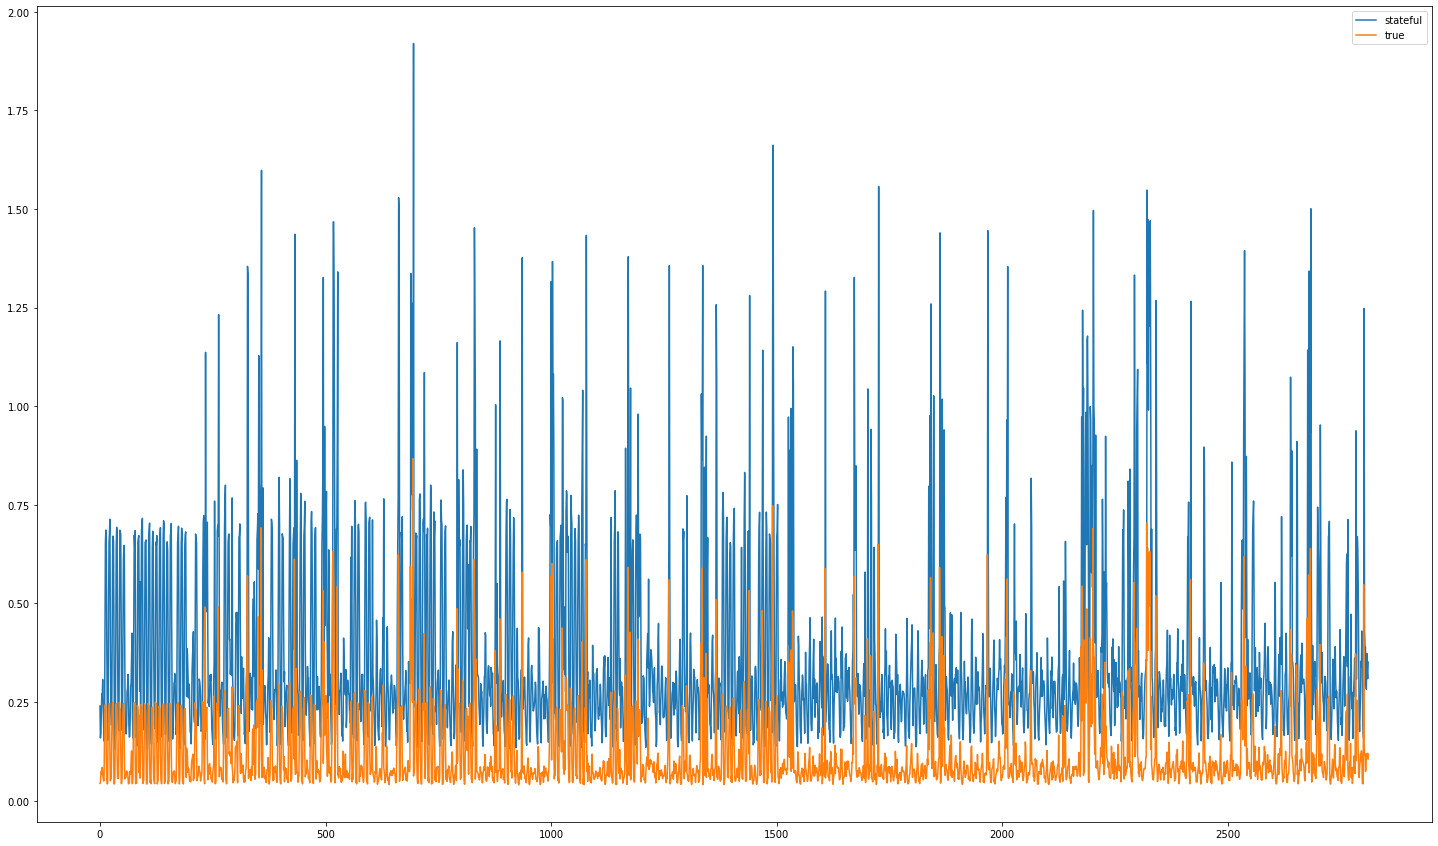

In [153]:
pd.DataFrame(pred_test).plot()

In [568]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [630]:
# multivariate cnn example

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = [],[]
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[207.06941]]


# Federated approach

In [90]:
import tensorflow as tf

In [169]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [185]:
class SimpleLSTM:
    @staticmethod
    def build(neurons, timesteps =1, n_features=1):
        model = Sequential()
        model.add(LSTM(neurons, input_shape =(timesteps,n_features)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
        
        
        return model

In [186]:
def weight_scalling_factor(clients_trn_data, client_name):
    #client_names = list(homes.columns())
    #get the bs
    #bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([len(clients_trn_data[client_name].dropna()) for client_name in client_names])
    # get the total number of data points held by a client
    local_count = len(clients_trn_data[client_name].dropna())
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error
    
def test_model(X_test, Y_test,  model, comm_round):
    preds = model.predict(X_test)
    loss = rmse(Y_test, preds)
    print('comm_round: {} | global_loss: {}'.format(comm_round,loss))
    return loss

In [187]:
def prepare_task(home: pd.Series, train_size= 0.9, timesteps= 1, epochs=50, batch_size= 64):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    #print(X_train.shape)

    return X_train, y_train, X_test, y_test

In [205]:
comms_round = 10
    
#create optimizer
lr = 0.01 
loss='mean_squared_error'
metrics = ['mse']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 



In [190]:
#initialize global model
smlp_global = SimpleLSTM()
global_model = smlp_global.build(256, 1, 1)
        


In [191]:
#test
global_weights = global_model.get_weights()
scaled_local_weight_list = list()

In [206]:
smlp_local = SimpleLSTM()
local_model = smlp_local.build(256,1,1)
local_model.compile(loss= loss, 
                    optimizer= optimizer,
                    metrics=metrics)   

In [207]:
local_model.set_weights(global_weights)

In [209]:
X_train, y_train, X_test, y_test = prepare_task(homes['total_a'])

local_model.fit(X_train, y_train, epochs=5, verbose=1)

Epoch 1/5
496/496 [==============================] - 6s 5ms/step - loss: 0.0103 - mse: 0.0103
Epoch 2/5
496/496 [==============================] - 3s 5ms/step - loss: 0.0093 - mse: 0.0093
Epoch 3/5
496/496 [==============================] - 3s 5ms/step - loss: 0.0088 - mse: 0.0088
Epoch 4/5
496/496 [==============================] - 2s 5ms/step - loss: 0.0084 - mse: 0.0084
Epoch 5/5
496/496 [==============================] - 3s 6ms/step - loss: 0.0081 - mse: 0.0081


In [210]:
#scale the model weights and add to list
scaling_factor = weight_scalling_factor(homes, 'total_a')
scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
scaled_local_weight_list.append(scaled_weights)

In [219]:
#to get the average over all the local model, we simply take the sum of the scaled weights
average_weights = sum_scaled_weights(scaled_local_weight_list)

#update global model 
global_model.set_weights(average_weights)

In [158]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()


    
    #loop through each client and create new local model
    for home in homes:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(256)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
       
 #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        X_train, y_train, X_test, y_test = prepare_task(homes[home])

        local_model.fit(X_train, y_train, epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(homes, home)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()

        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)


(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)
(15851, 1, 1)
(23651, 1, 1)
(31210, 1, 1)
(13000, 1, 1)
(31556, 1, 1)
(13360, 1, 1)
(4089, 1, 1)


In [ ]:
    
    
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_loss = test_model(X_test, Y_test, global_model, comm_round)
        SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleLSTM()
SGD_model = smlp_SGD.build(784, 10) 

SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=100, verbose=0)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

In [ ]:
    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    
    pred_train ={}
    pred_test = {}

    rmse_train ={}
    rmse_test = {}

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train["simple_lstm"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #plot the predictions
    plt.plot(pred_test['true'])
    plt.plot(pred_test['simple_lstm'])
    plt.show()


    rmse_test['single'] = rmse(pred_test['true'], pred_test['simple_lstm'])
    rmse_train['single'] = rmse(pred_train['true'], pred_train['simple_lstm'])

  
    print(f"The RMSE in the train set is: {rmse_train['single']}")
    print(f"The RMSE in the test set is: {rmse_test['single']}")

# Normal training

(15851, 1, 1)
Epoch 1/10
248/248 - 3s - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0061 - val_mse: 0.0061 - 3s/epoch - 12ms/step
Epoch 2/10
248/248 - 1s - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 4ms/step
Epoch 3/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 6ms/step
Epoch 4/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 6ms/step
Epoch 5/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 5ms/step
Epoch 6/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 5ms/step
Epoch 7/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0060 - val_mse: 0.0060 - 1s/epoch - 4ms/step
Epoch 8/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0060 - val_mse: 0.0060 - 1s/epoch - 5ms/step
Epoch 9/10
248/248 - 1s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0060 - val_mse: 0.0060

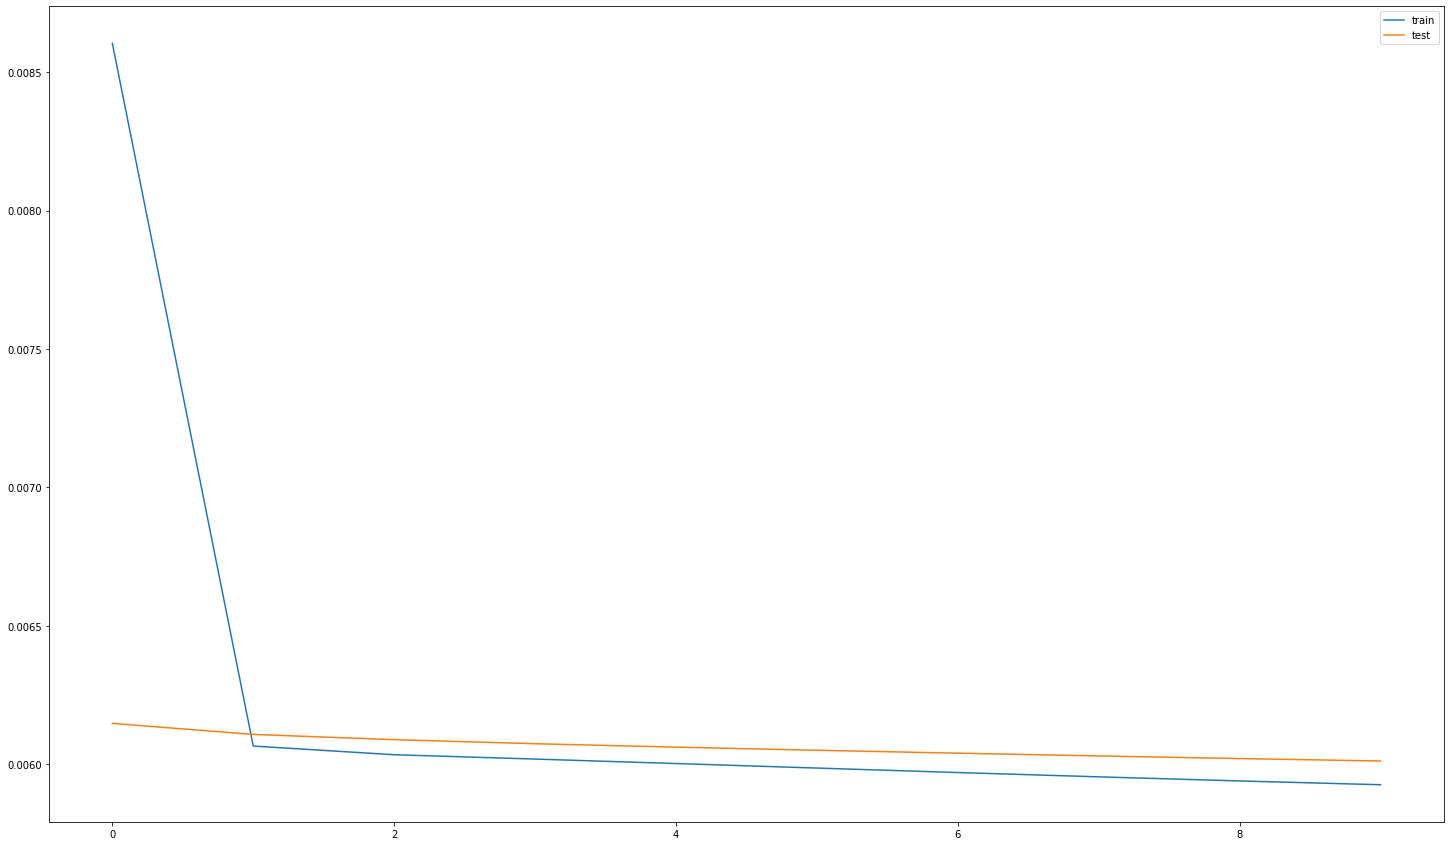

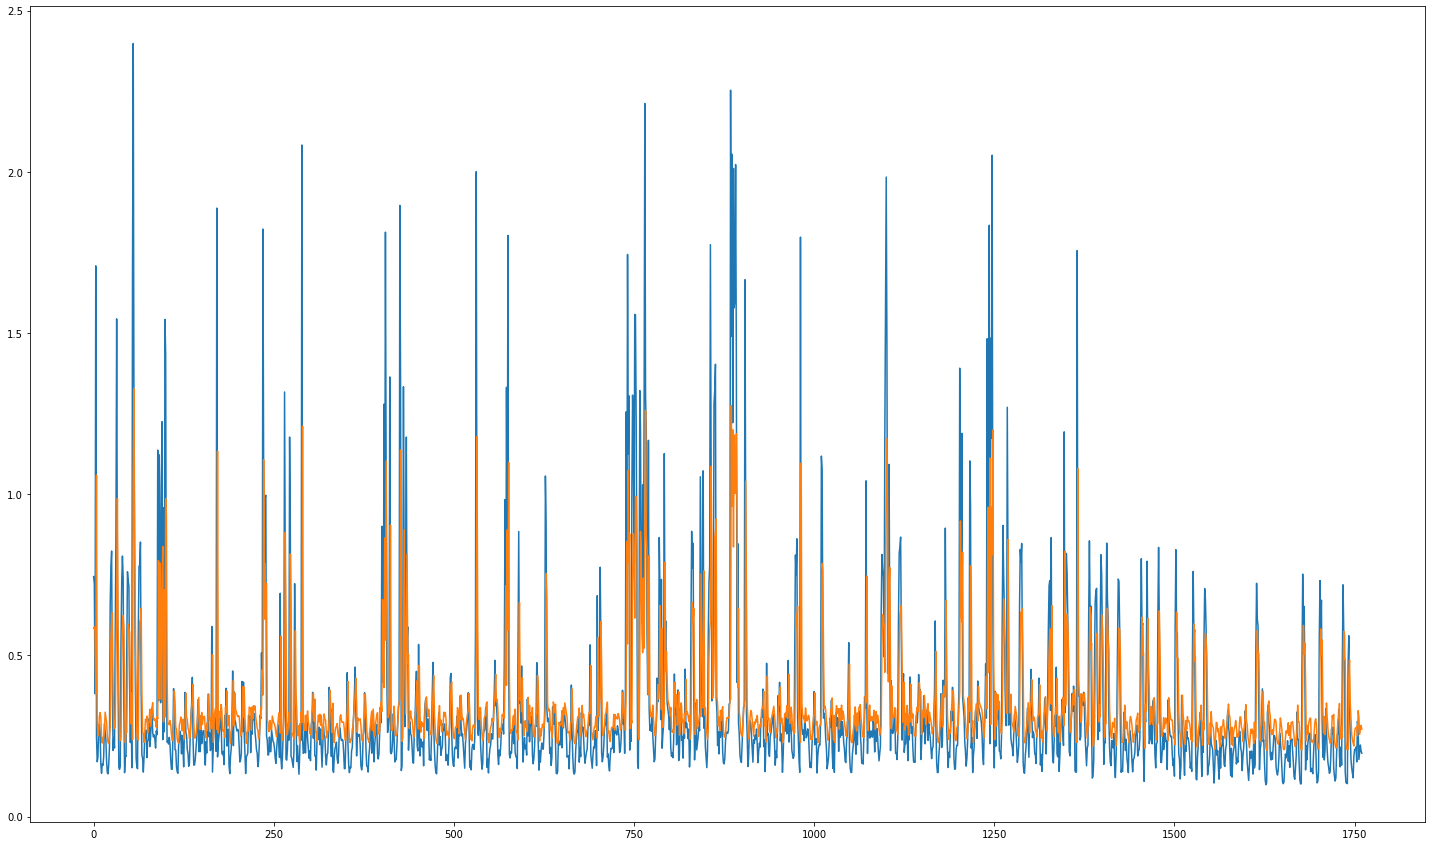

The RMSE in the train set is: 0.25209366327433724
The RMSE in the test set is: 0.24857797093525907
(23651, 1, 1)
Epoch 1/10
370/370 - 4s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0013 - val_mse: 0.0013 - 4s/epoch - 10ms/step
Epoch 2/10
370/370 - 2s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 6ms/step
Epoch 3/10
370/370 - 2s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 6ms/step
Epoch 4/10
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 6ms/step
Epoch 5/10
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 5ms/step
Epoch 6/10
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 6ms/step
Epoch 7/10
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 6ms/step
Epoch 8/10
370/370 - 2s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch -

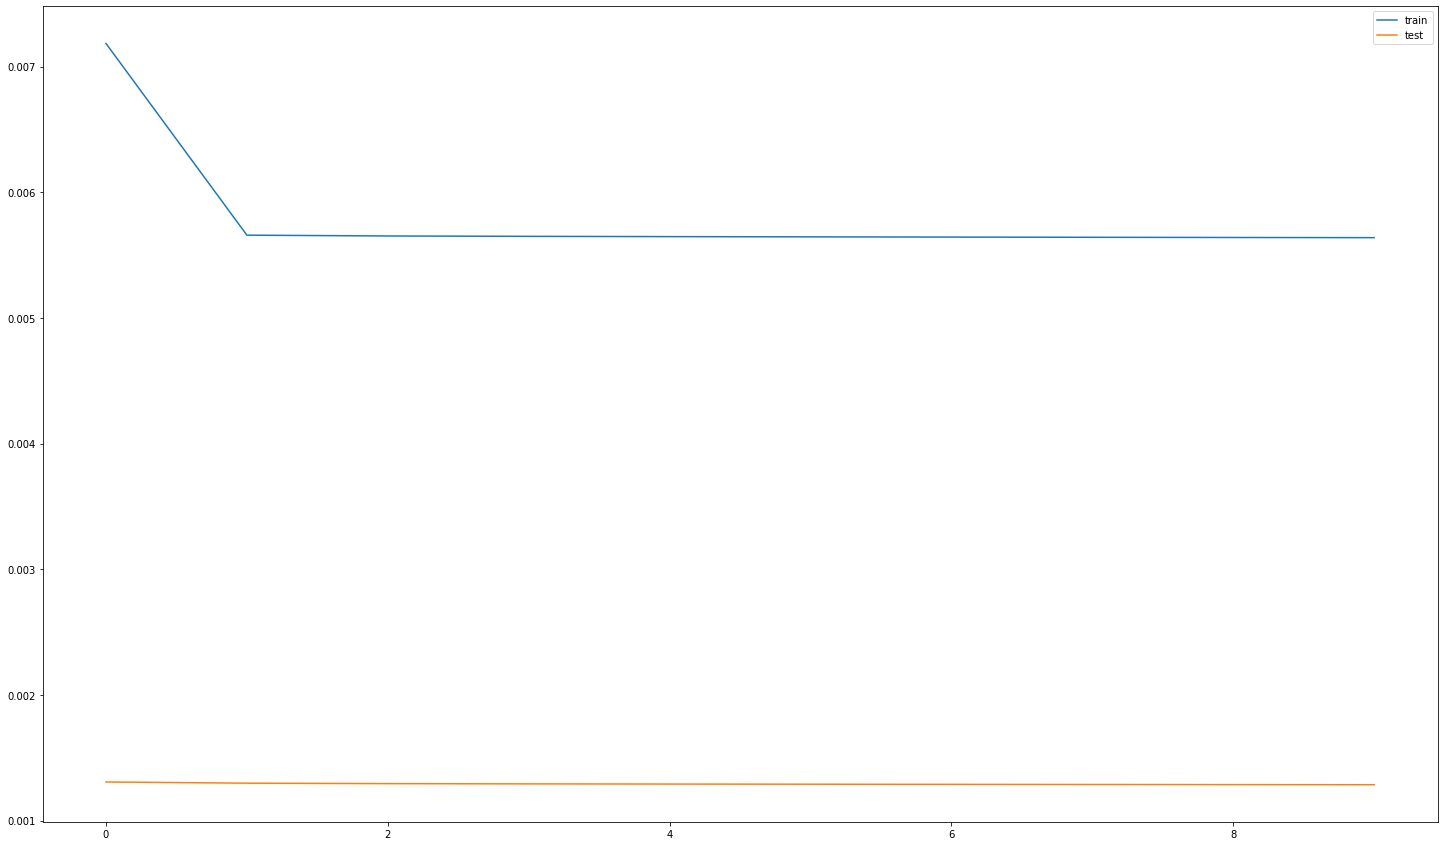

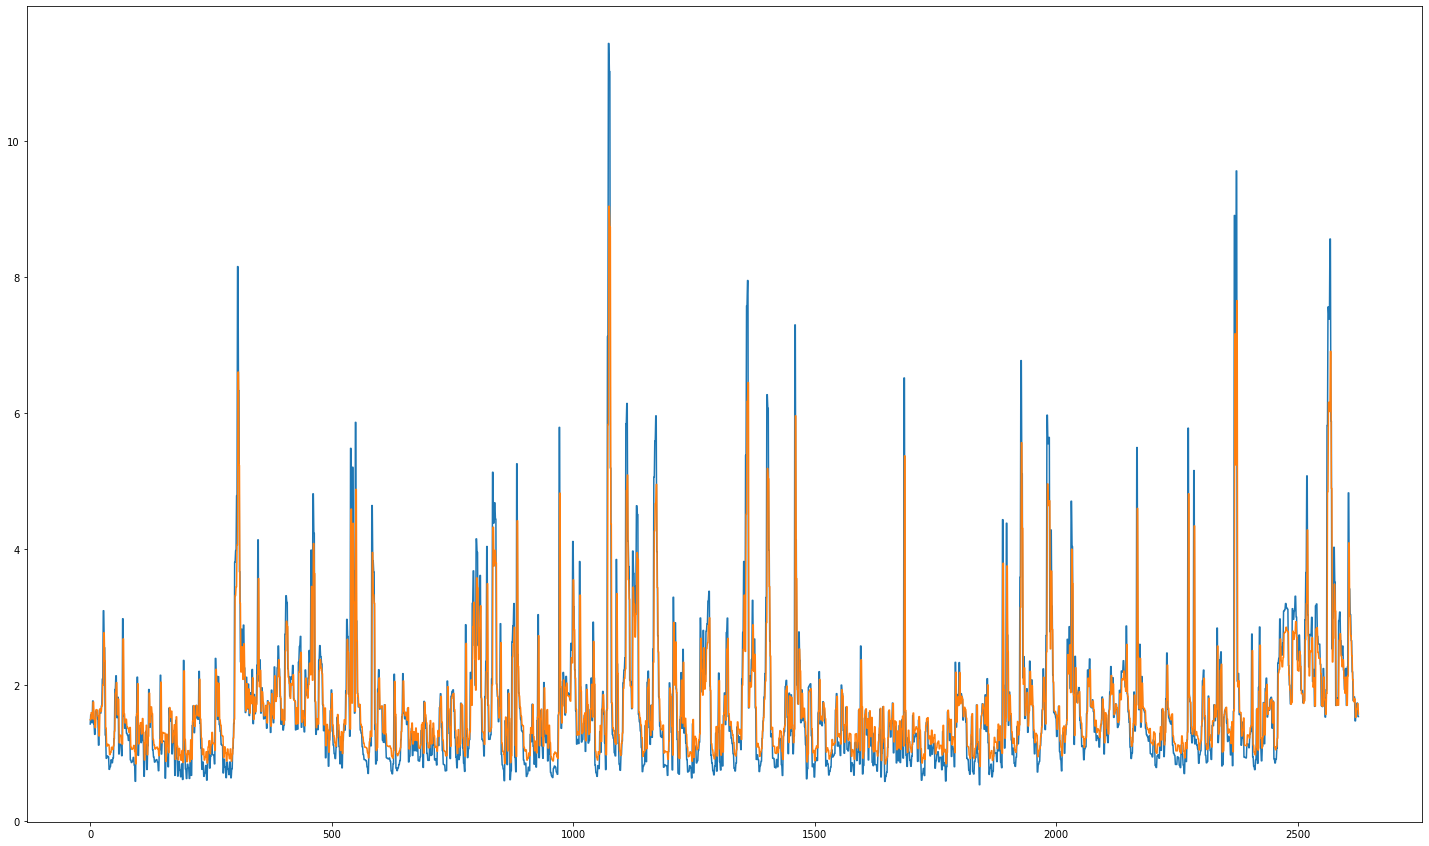

The RMSE in the train set is: 1.427972567792498
The RMSE in the test set is: 0.6695132293736057
(31210, 1, 1)
Epoch 1/10
488/488 - 6s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0051 - val_mse: 0.0051 - 6s/epoch - 12ms/step
Epoch 2/10
488/488 - 3s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0051 - val_mse: 0.0051 - 3s/epoch - 6ms/step
Epoch 3/10
488/488 - 3s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 3s/epoch - 7ms/step
Epoch 4/10
488/488 - 2s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 2s/epoch - 5ms/step
Epoch 5/10
488/488 - 2s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 2s/epoch - 5ms/step
Epoch 6/10
488/488 - 3s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 3s/epoch - 5ms/step
Epoch 7/10
488/488 - 3s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 3s/epoch - 7ms/step
Epoch 8/10
488/488 - 3s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 3s/epoch - 6m

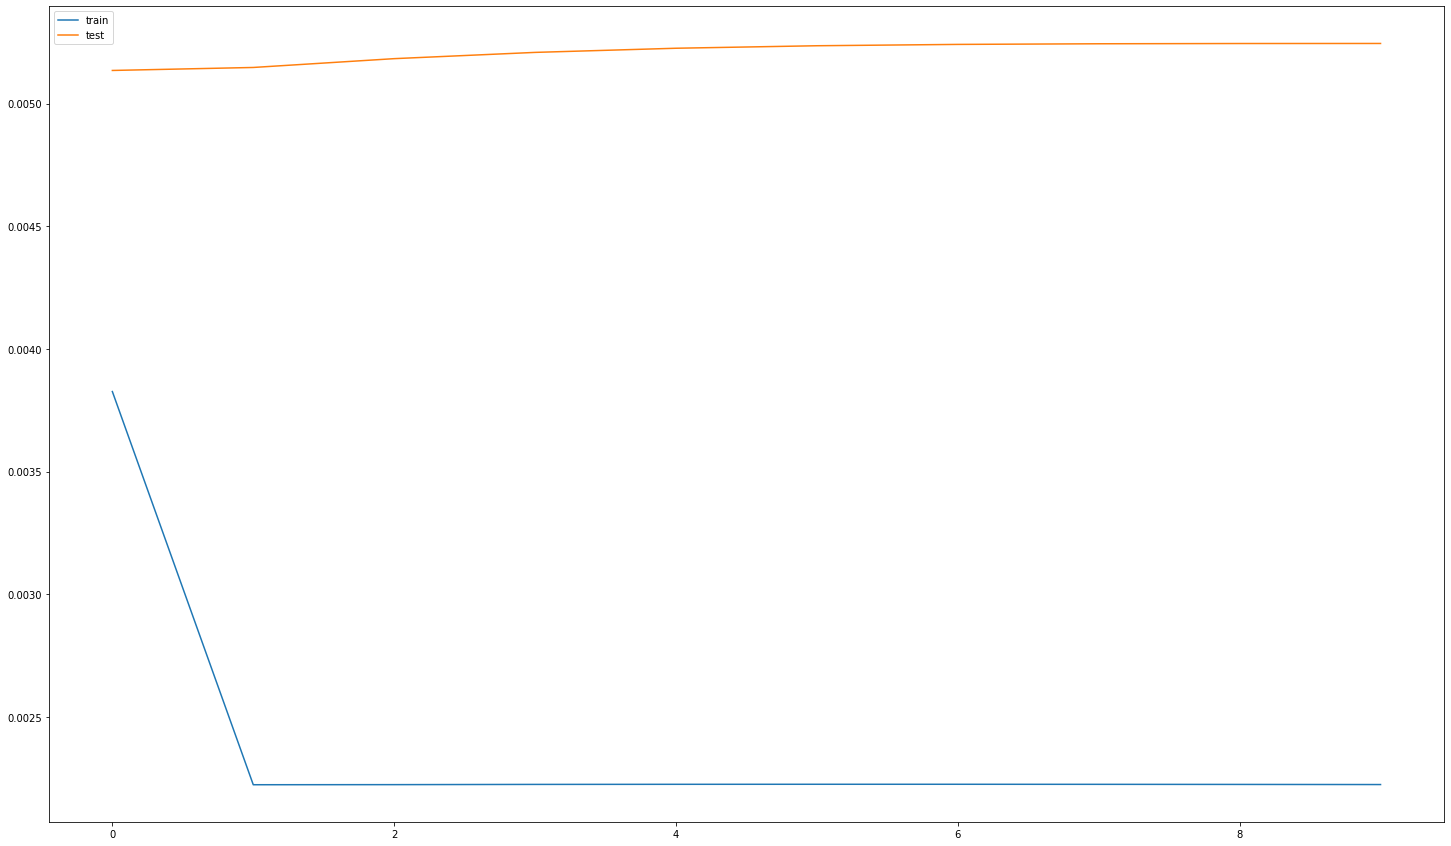

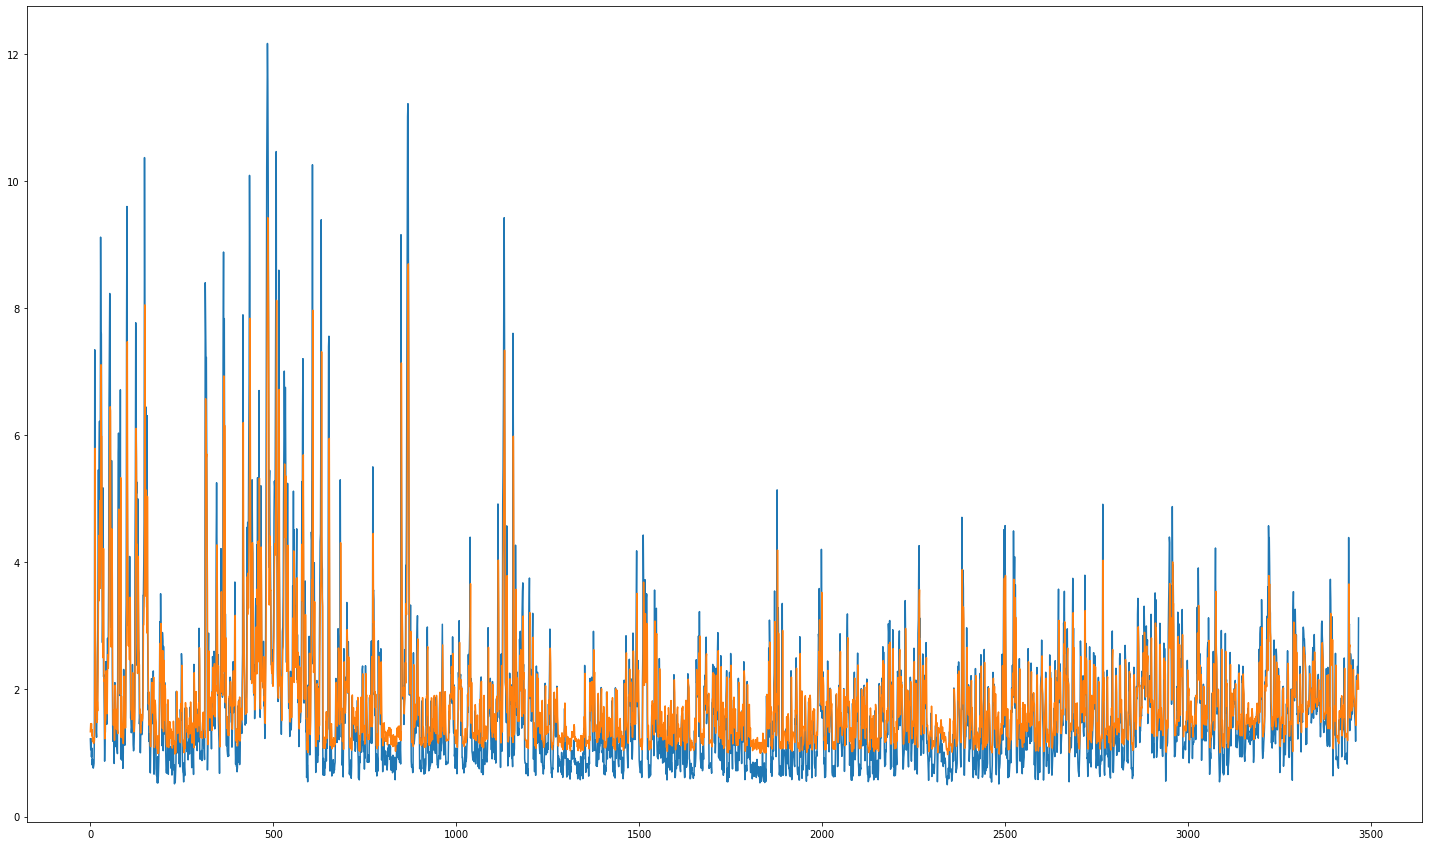

The RMSE in the train set is: 0.5602399027524886
The RMSE in the test set is: 0.8135251783064535
(13000, 1, 1)
Epoch 1/10
204/204 - 3s - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0069 - val_mse: 0.0069 - 3s/epoch - 14ms/step
Epoch 2/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 920ms/epoch - 5ms/step
Epoch 3/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 861ms/epoch - 4ms/step
Epoch 4/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 857ms/epoch - 4ms/step
Epoch 5/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 861ms/epoch - 4ms/step
Epoch 6/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 941ms/epoch - 5ms/step
Epoch 7/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 932ms/epoch - 5ms/step
Epoch 8/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0

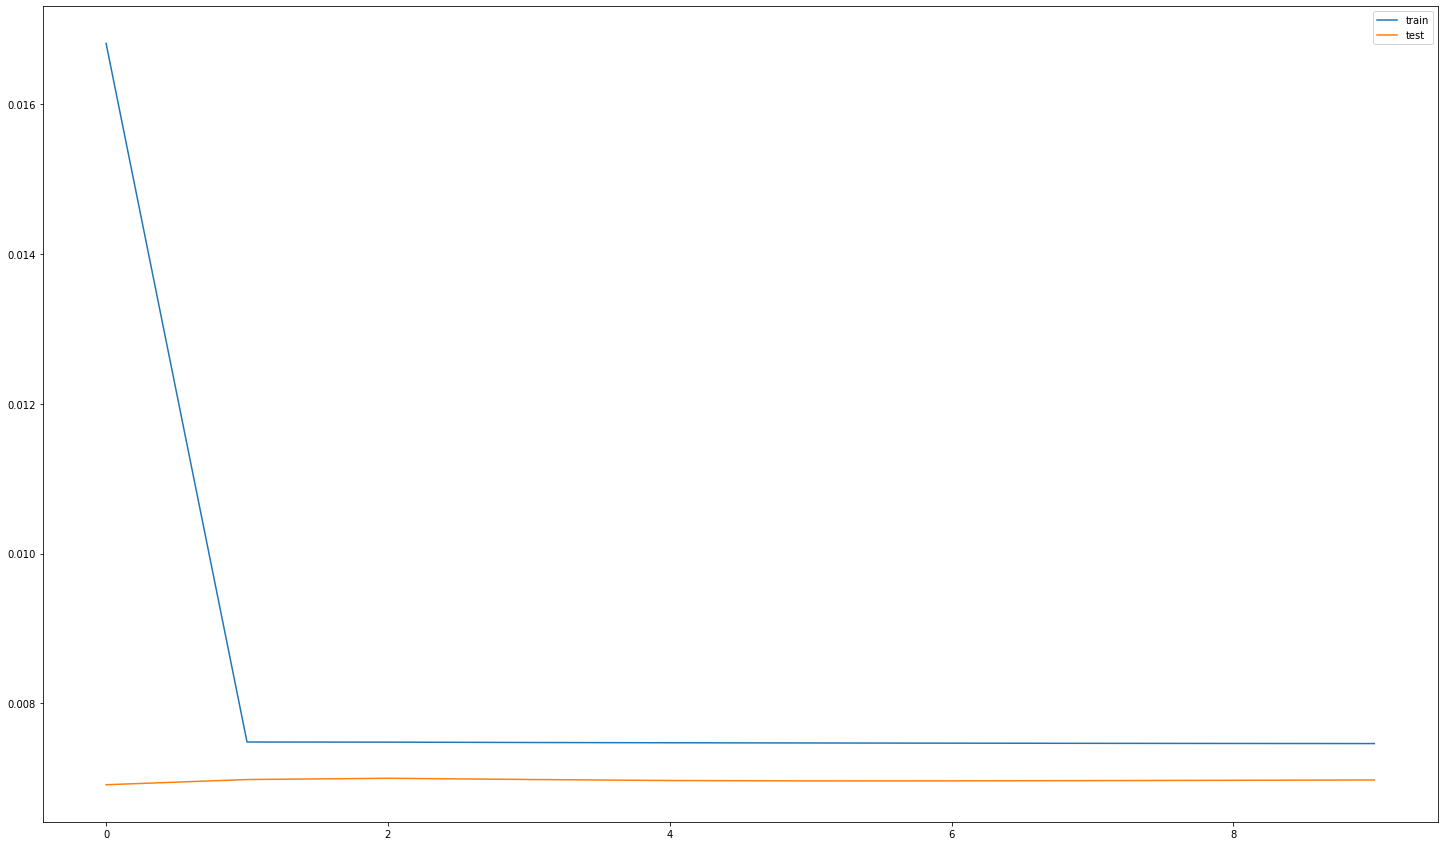

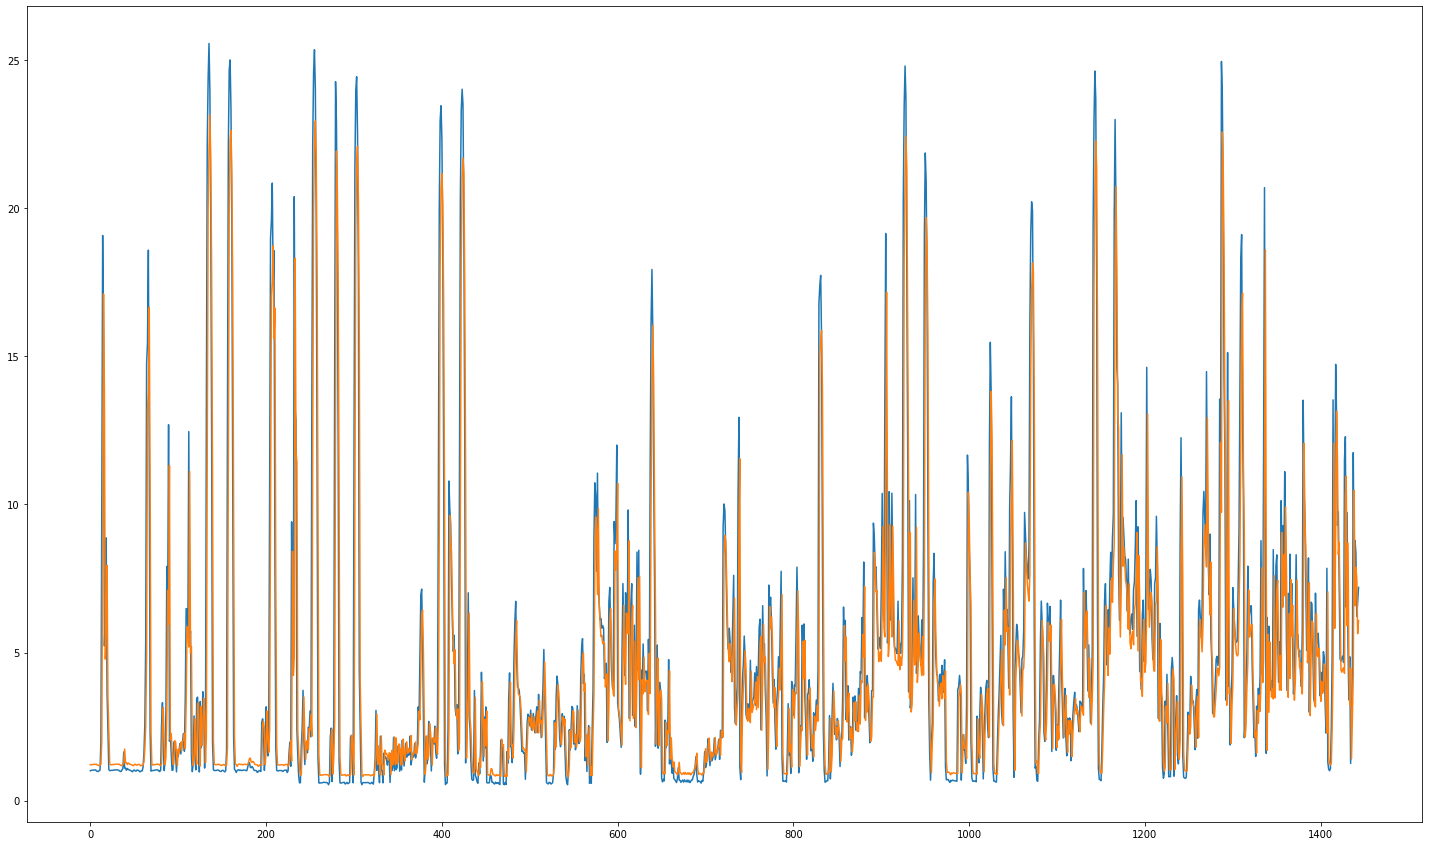

The RMSE in the train set is: 2.853440537026192
The RMSE in the test set is: 2.7364759223955115
(31556, 1, 1)
Epoch 1/10
494/494 - 4s - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0013 - val_mse: 0.0013 - 4s/epoch - 9ms/step
Epoch 2/10
494/494 - 3s - loss: 8.6106e-04 - mse: 8.6106e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 3s/epoch - 5ms/step
Epoch 3/10
494/494 - 3s - loss: 8.6064e-04 - mse: 8.6064e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 3s/epoch - 6ms/step
Epoch 4/10
494/494 - 3s - loss: 8.5886e-04 - mse: 8.5886e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 3s/epoch - 6ms/step
Epoch 5/10
494/494 - 3s - loss: 8.5683e-04 - mse: 8.5683e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 3s/epoch - 5ms/step
Epoch 6/10
494/494 - 3s - loss: 8.5483e-04 - mse: 8.5483e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 3s/epoch - 6ms/step
Epoch 7/10
494/494 - 4s - loss: 8.5292e-04 - mse: 8.5292e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 4s/epoch - 7ms/step
Epoch 8/10
494/494 - 2s - loss: 8.5114e-04 - mse: 8.5114e-

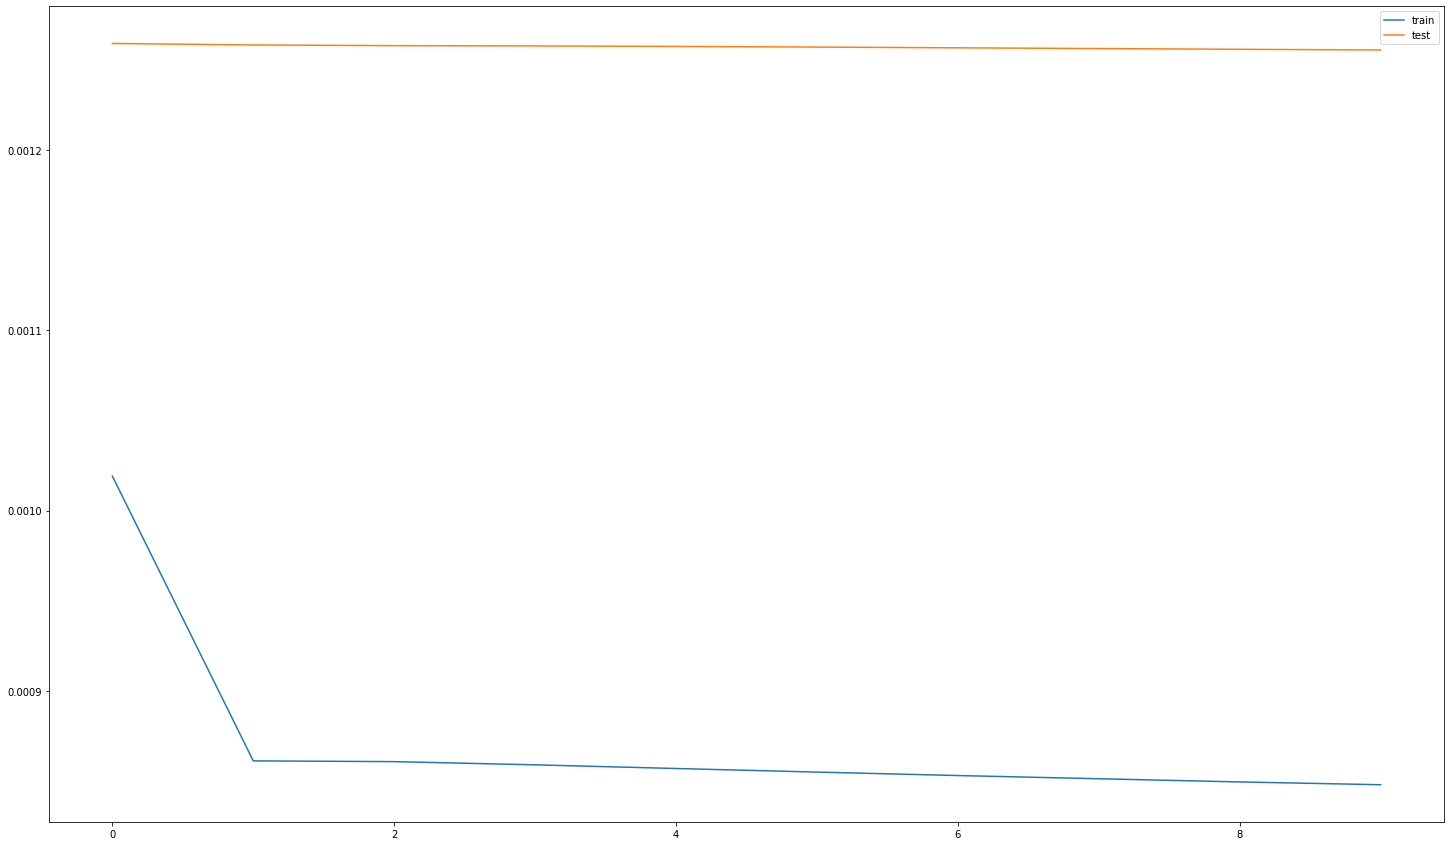

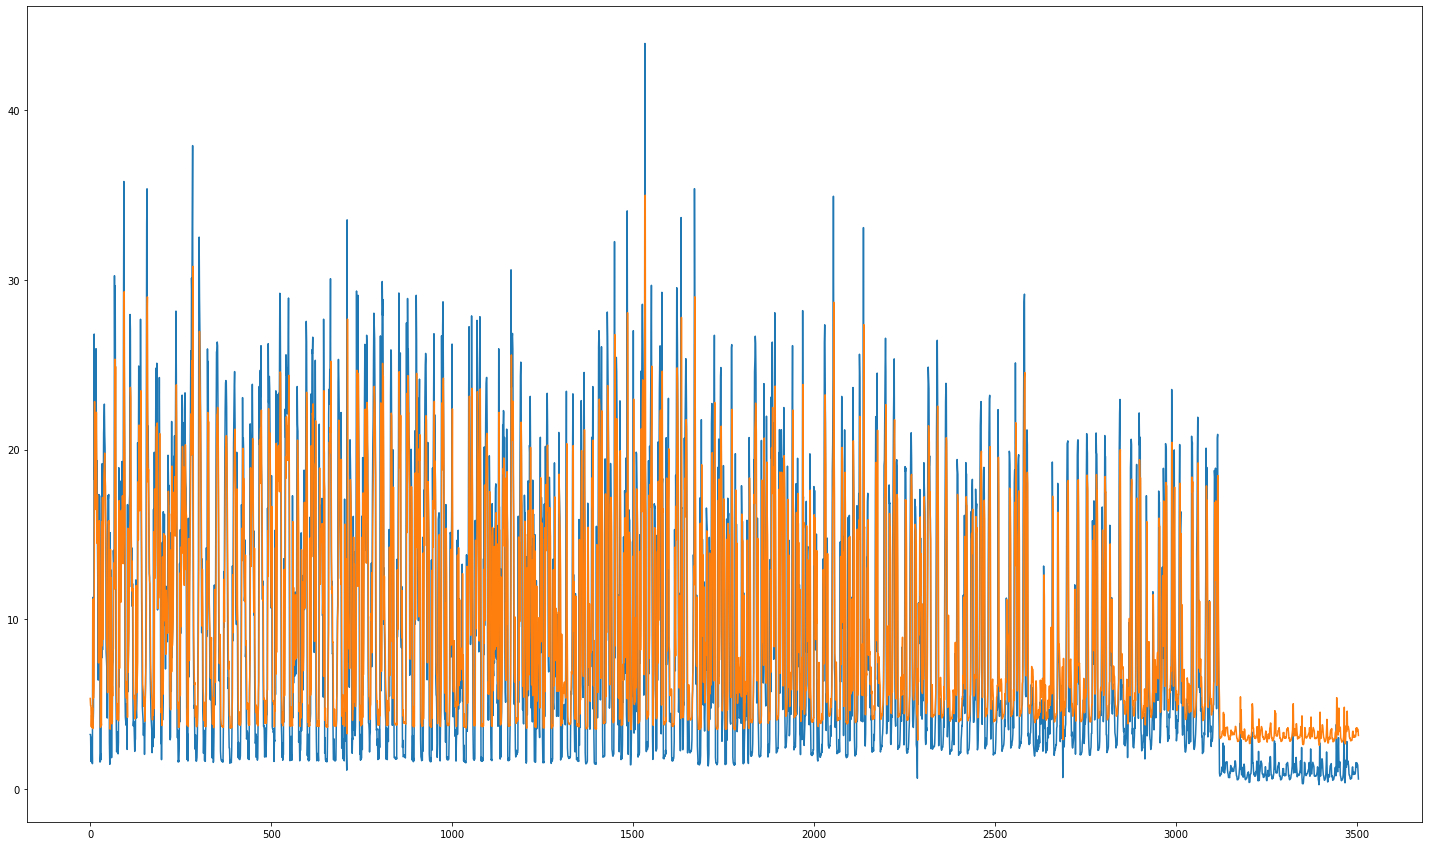

The RMSE in the train set is: 4.306891305782883
The RMSE in the test set is: 5.1391980768588565
(13360, 1, 1)
Epoch 1/10
209/209 - 3s - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0164 - val_mse: 0.0164 - 3s/epoch - 14ms/step
Epoch 2/10
209/209 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0133 - val_mse: 0.0133 - 873ms/epoch - 4ms/step
Epoch 3/10
209/209 - 1s - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0114 - val_mse: 0.0114 - 864ms/epoch - 4ms/step
Epoch 4/10
209/209 - 1s - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0105 - val_mse: 0.0105 - 864ms/epoch - 4ms/step
Epoch 5/10
209/209 - 1s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0101 - val_mse: 0.0101 - 906ms/epoch - 4ms/step
Epoch 6/10
209/209 - 1s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0099 - val_mse: 0.0099 - 1s/epoch - 6ms/step
Epoch 7/10
209/209 - 1s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0099 - val_mse: 0.0099 - 1s/epoch - 6ms/step
Epoch 8/10
209/209 - 1s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0098 - val_mse: 0.0098 - 1

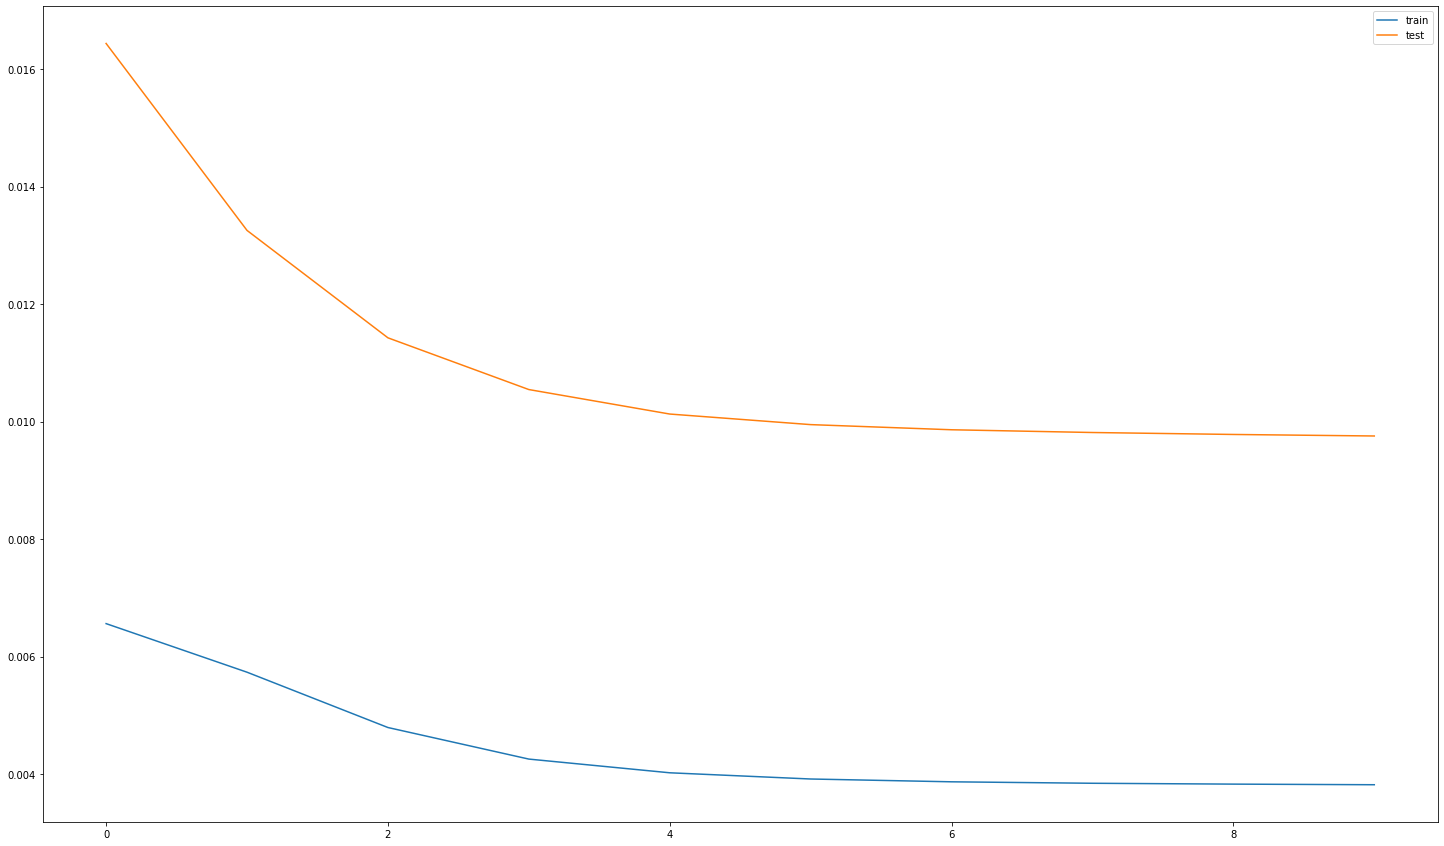

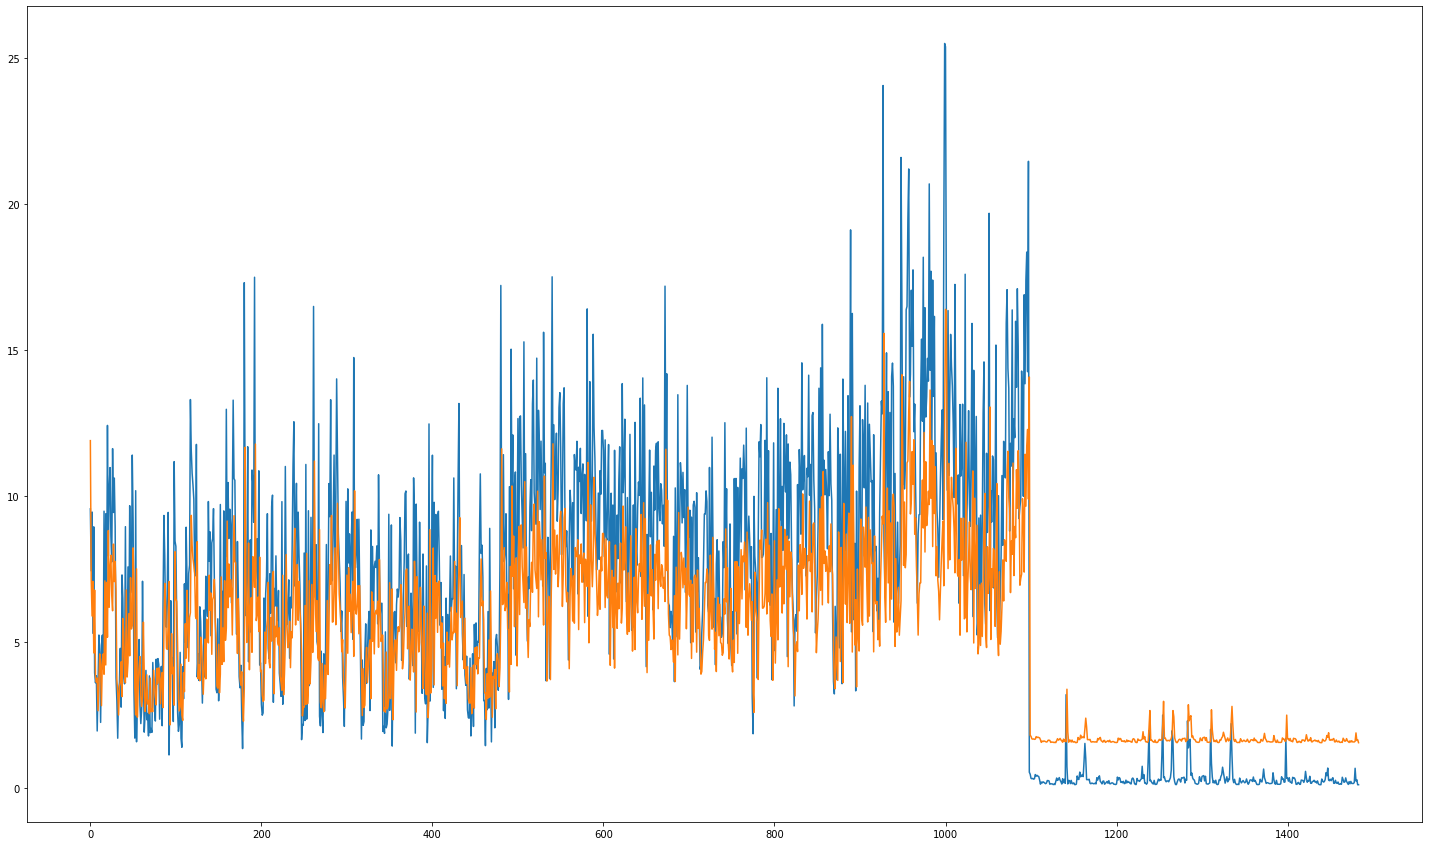

The RMSE in the train set is: 2.565202677117437
The RMSE in the test set is: 3.353913880449188
(4089, 1, 1)
Epoch 1/10
64/64 - 3s - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0126 - val_mse: 0.0126 - 3s/epoch - 44ms/step
Epoch 2/10
64/64 - 0s - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0114 - val_mse: 0.0114 - 328ms/epoch - 5ms/step
Epoch 3/10
64/64 - 0s - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0110 - val_mse: 0.0110 - 483ms/epoch - 8ms/step
Epoch 4/10
64/64 - 0s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0109 - val_mse: 0.0109 - 471ms/epoch - 7ms/step
Epoch 5/10
64/64 - 1s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0109 - val_mse: 0.0109 - 528ms/epoch - 8ms/step
Epoch 6/10
64/64 - 0s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0109 - val_mse: 0.0109 - 354ms/epoch - 6ms/step
Epoch 7/10
64/64 - 0s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0108 - val_mse: 0.0108 - 331ms/epoch - 5ms/step
Epoch 8/10
64/64 - 0s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0108 - val_mse: 0.0108 - 471ms/epoch -

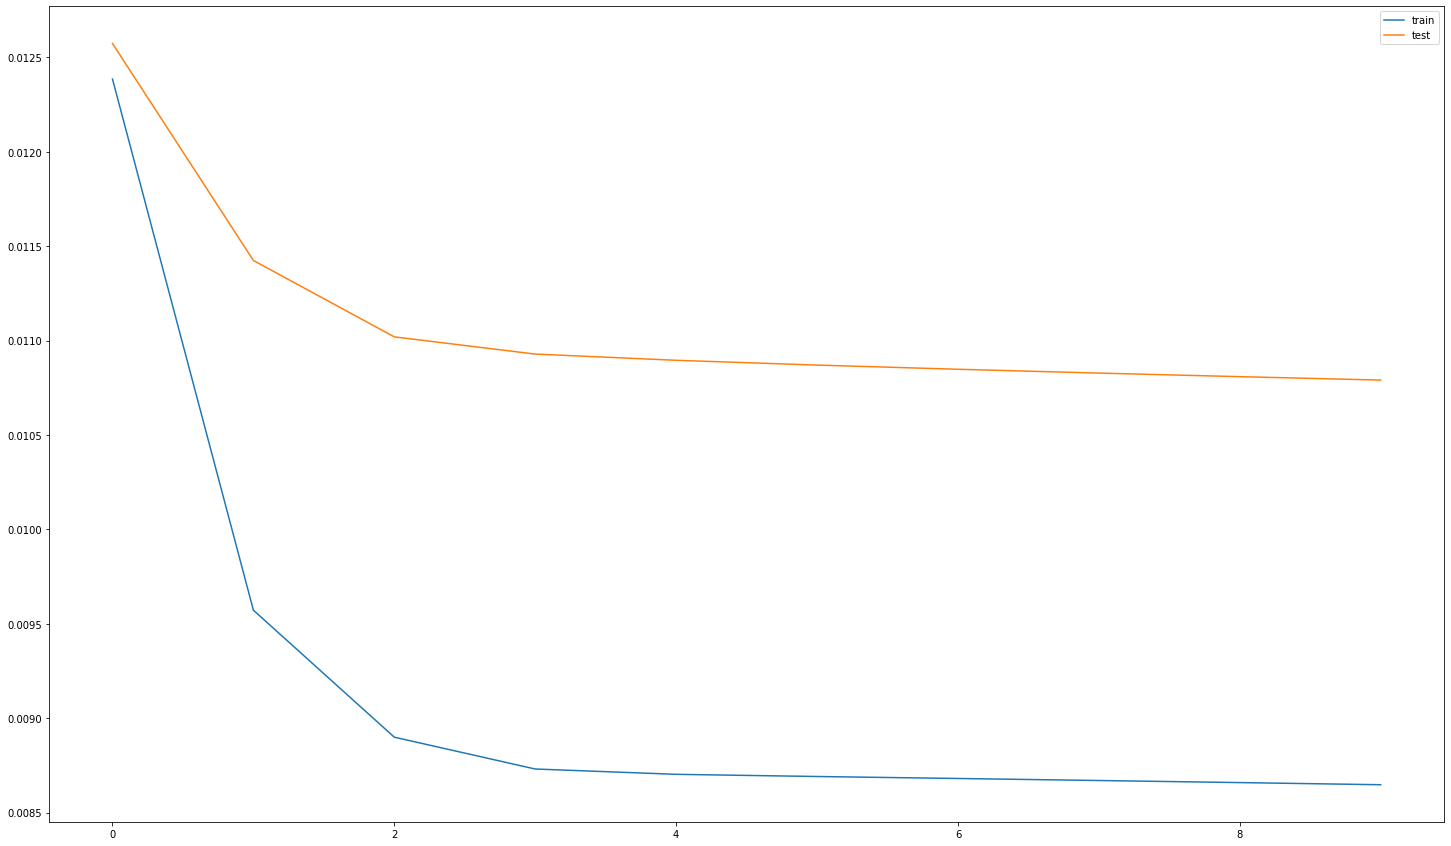

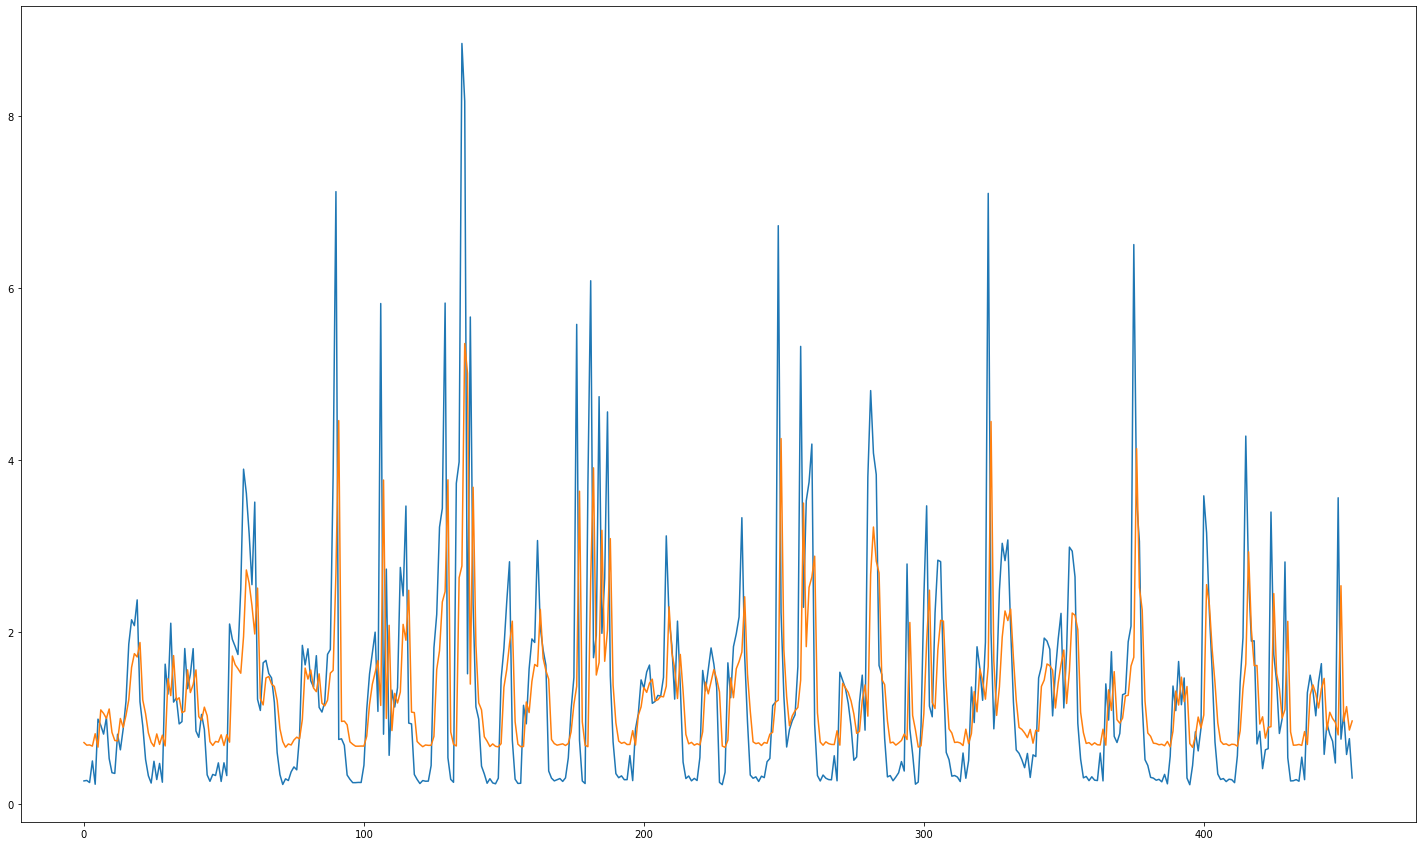

The RMSE in the train set is: 0.99310478559118
The RMSE in the test set is: 1.110407566880701


In [102]:
for home in homes: 
    run_model(homes[home], train_size=0.9, epochs=10)